In [ ]:
# train_adaptive_fusion.py
import os, time, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.amp import autocast, GradScaler   # <- NEW API
from sklearn.metrics import roc_auc_score

from adaptive_fusion_model_v4 import AdaptiveFusionClassifier
from dataloader import get_dataloaders


def set_global_seed(seed: int = 1337):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.detach().clone()
                       for n, p in model.named_parameters()
                       if p.requires_grad}

    @torch.no_grad()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    @torch.no_grad()
    def apply_to(self, model):
        self._backup = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self._backup[n] = p.detach().clone()
                p.copy_(self.shadow[n])

    @torch.no_grad()
    def restore(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self._backup:
                p.copy_(self._backup[n])
        self._backup = {}


def masked_macro_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    C = y_true_np.shape[1]
    scores = []
    for c in range(C):
        m = mask[:, c]
        if m.sum() == 0:
            continue
        yt = y_true_np[m].astype(np.int32)[:, c]
        yp = y_prob_np[m][:, c]
        if yt.max() == yt.min():
            continue
        scores.append(roc_auc_score(yt, yp))
    return float(np.mean(scores)) if scores else float("nan")


def main():
    # ---- config ----
    set_global_seed(1337)

    data_dir    = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2"
    batch_size  = 16
    num_workers = 4

    n_epochs    = 30
    lr          = 1e-4
    weight_decay = 1e-5
    use_amp     = torch.cuda.is_available()
    enable_ema  = True
    ema_decay   = 0.999
    cxr_backbone = "densenet121"  # or "resnet50", "efficientnet_b2", "convnext_tiny"

    save_path   = f"./checkpoints/adaptive_fusion_v4_{cxr_backbone}.pt"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    gates_csv   = f"./gate_trends_v4_{cxr_backbone}.csv"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- data ----
    train_loader, val_loader, test_loader = get_dataloaders(
        data_dir, batch_size=batch_size, num_workers=num_workers
    )

    # ---- model ----
    model = AdaptiveFusionClassifier(
        num_classes=14,
        lr=lr,
        lab_input_dim=100,
        dropout_prob=0.2,
        cxr_backbone=cxr_backbone,
        lambda_gate_entropy=0.005,
        lambda_gate_diversity=0.005
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = GradScaler(device="cuda", enabled=use_amp)   # <- NEW

    ema = EMA(model, decay=ema_decay) if enable_ema else None

    # ---- tracking ----
    best_val_auroc = 0.0
    gate_stats = []

    # ---- loop ----
    for epoch in range(n_epochs):
        model.train()
        model.set_epoch(epoch)  # <- NEW: drives dropout annealing inside model

        # manual extra-smooth gates for first 2 epochs (matches previous behavior)
        if epoch < 2:
            with torch.no_grad():
                model.fusion.temperature.fill_(max(model.hparams.gate_init_temp, 2.0))

        epoch_start = time.perf_counter()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        train_loss_sum = 0.0
        y_true_train, y_prob_train = [], []

        print(f"\nEpoch {epoch+1}/{n_epochs}")

        for cxr, ecg, labs, y in tqdm(train_loader, desc="Training", leave=False):
            cxr = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type="cuda", enabled=use_amp):  # <- NEW
                logits, gates = model(cxr, ecg, labs, return_gates=True)
                bce = model.masked_bce_loss(logits, y)

                # tiny gate regularizers (same λs as model)
                eps = 1e-8
                entropy = (-(gates * (gates + eps).log()).sum(dim=1)).mean()
                batch_var = gates.var(dim=0).mean()
                loss = bce + model.hparams.lambda_gate_entropy * entropy - model.hparams.lambda_gate_diversity * batch_var

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                model.fusion.step_temperature()  # anneal gate temp per step

            train_loss_sum += loss.item()
            with torch.no_grad():
                y_prob_train.append(torch.sigmoid(logits).cpu().numpy())
                y_true_train.append(y.cpu().numpy())

            if ema is not None:
                ema.update(model)

        y_prob_train = np.concatenate(y_prob_train)
        y_true_train = np.concatenate(y_true_train)
        train_auroc = masked_macro_auroc(y_true_train, y_prob_train)
        avg_train_loss = train_loss_sum / max(1, len(train_loader))

        # ---- validation (EMA weights) ----
        if ema is not None:
            ema.apply_to(model)

        model.eval()
        val_loss_sum = 0.0
        y_true_val, y_prob_val = [], []
        all_gates = []

        with torch.no_grad(), autocast(device_type="cuda", enabled=use_amp):
            for cxr, ecg, labs, y in tqdm(val_loader, desc="Validation", leave=False):
                cxr = cxr.to(device).float()
                labs = labs.to(device).float()
                y    = y.to(device)

                ecg = ecg.to(device).float()
                if ecg.ndim == 4 and ecg.shape[1] == 1:
                    ecg = ecg.squeeze(1)
                if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                    ecg = ecg.permute(0, 2, 1)

                logits, gates = model(cxr, ecg, labs, return_gates=True)
                loss = model.masked_bce_loss(logits, y)
                val_loss_sum += loss.item()

                y_prob_val.append(torch.sigmoid(logits).cpu().numpy())
                y_true_val.append(y.cpu().numpy())
                all_gates.append(gates.cpu().numpy())

        if ema is not None:
            ema.restore(model)

        y_prob_val = np.concatenate(y_prob_val)
        y_true_val = np.concatenate(y_true_val)
        all_gates  = np.concatenate(all_gates)

        val_auroc = masked_macro_auroc(y_true_val, y_prob_val)
        avg_val_loss = val_loss_sum / max(1, len(val_loader))

        gate_ecg  = float(all_gates[:, 0].mean())
        gate_cxr  = float(all_gates[:, 1].mean())
        gate_labs = float(all_gates[:, 2].mean())

        epoch_sec = time.perf_counter() - epoch_start
        peak_mem_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

        print(f"Train Loss: {avg_train_loss:.4f} | Train AUROC (macro): {train_auroc:.4f}")
        print(f"Val   Loss: {avg_val_loss:.4f} | Val   AUROC (macro): {val_auroc:.4f}")
        print(f" Avg Gate Weights → ECG: {gate_ecg:.3f} | CXR: {gate_cxr:.3f} | Labs: {gate_labs:.3f}")
        print(f" Epoch time: {epoch_sec:.1f}s | Peak GPU mem: {peak_mem_gb:.2f} GB")

        if val_auroc > best_val_auroc:
            best_val_auroc = val_auroc
            torch.save(model.state_dict(), save_path)
            print(f" Best model saved at epoch {epoch+1} with AUROC: {val_auroc:.4f} → {save_path}")

        gate_stats.append({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "train_auroc_macro": train_auroc,
            "val_auroc_macro": val_auroc,
            "gate_ecg": gate_ecg,
            "gate_cxr": gate_cxr,
            "gate_labs": gate_labs,
            "epoch_sec": epoch_sec,
            "peak_mem_GB": peak_mem_gb
        })
        pd.DataFrame(gate_stats).to_csv(gates_csv, index=False)

    print(f"\nTraining complete. Best Val AUROC (macro): {best_val_auroc:.4f}")
    print(f"Gate trends saved to: {gates_csv}")
    print(f"Best checkpoint: {save_path}")


if __name__ == "__main__":
    main()


/data/mahjabeen_workspace/Summer25_Project/symile/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1/30


Train Loss: 0.4585 | Train AUROC (macro): 0.5028
Val   Loss: 0.5363 | Val   AUROC (macro): 0.5268
 Avg Gate Weights → ECG: 0.178 | CXR: 0.708 | Labs: 0.115
 Epoch time: 58.5s | Peak GPU mem: 2.38 GB
 Best model saved at epoch 1 with AUROC: 0.5268 → ./checkpoints/adaptive_fusion_v4_densenet121.pt

Epoch 2/30


Train Loss: 0.4389 | Train AUROC (macro): 0.5001
Val   Loss: 0.4575 | Val   AUROC (macro): 0.5515
 Avg Gate Weights → ECG: 0.026 | CXR: 0.970 | Labs: 0.004
 Epoch time: 56.8s | Peak GPU mem: 2.38 GB
 Best model saved at epoch 2 with AUROC: 0.5515 → ./checkpoints/adaptive_fusion_v4_densenet121.pt

Epoch 3/30


Train Loss: 0.4360 | Train AUROC (macro): 0.5192
Val   Loss: 0.4354 | Val   AUROC (macro): 0.5301
 Avg Gate Weights → ECG: 0.002 | CXR: 0.998 | Labs: 0.000
 Epoch time: 57.6s | Peak GPU mem: 2.38 GB

Epoch 4/30


Train Loss: 0.4339 | Train AUROC (macro): 0.5177
Val   Loss: 0.4290 | Val   AUROC (macro): 0.5695
 Avg Gate Weights → ECG: 0.000 | CXR: 0.999 | Labs: 0.000
 Epoch time: 57.8s | Peak GPU mem: 2.38 GB
 Best model saved at epoch 4 with AUROC: 0.5695 → ./checkpoints/adaptive_fusion_v4_densenet121.pt

Epoch 5/30


Train Loss: 0.4339 | Train AUROC (macro): 0.5395
Val   Loss: 0.4285 | Val   AUROC (macro): 0.5223
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 58.1s | Peak GPU mem: 2.38 GB

Epoch 6/30


Train Loss: 0.4317 | Train AUROC (macro): 0.5422
Val   Loss: 0.4280 | Val   AUROC (macro): 0.5635
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.5s | Peak GPU mem: 2.38 GB

Epoch 7/30


Train Loss: 0.4284 | Train AUROC (macro): 0.5763
Val   Loss: 0.4311 | Val   AUROC (macro): 0.5534
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.6s | Peak GPU mem: 2.38 GB

Epoch 8/30


Train Loss: 0.4274 | Train AUROC (macro): 0.5659
Val   Loss: 0.4295 | Val   AUROC (macro): 0.5592
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.5s | Peak GPU mem: 2.38 GB

Epoch 9/30


Train Loss: 0.4243 | Train AUROC (macro): 0.5954
Val   Loss: 0.4356 | Val   AUROC (macro): 0.5597
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.7s | Peak GPU mem: 2.38 GB

Epoch 10/30


Train Loss: 0.4187 | Train AUROC (macro): 0.6276
Val   Loss: 0.4342 | Val   AUROC (macro): 0.5775
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB
 Best model saved at epoch 10 with AUROC: 0.5775 → ./checkpoints/adaptive_fusion_v4_densenet121.pt

Epoch 11/30


Train Loss: 0.4119 | Train AUROC (macro): 0.6497
Val   Loss: 0.4318 | Val   AUROC (macro): 0.5767
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.5s | Peak GPU mem: 2.38 GB

Epoch 12/30


Train Loss: 0.3956 | Train AUROC (macro): 0.7073
Val   Loss: 0.4421 | Val   AUROC (macro): 0.5648
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.3s | Peak GPU mem: 2.38 GB

Epoch 13/30


Train Loss: 0.3692 | Train AUROC (macro): 0.7595
Val   Loss: 0.4504 | Val   AUROC (macro): 0.5653
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.3s | Peak GPU mem: 2.38 GB

Epoch 14/30


Train Loss: 0.3298 | Train AUROC (macro): 0.8179
Val   Loss: 0.4519 | Val   AUROC (macro): 0.5812
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB
 Best model saved at epoch 14 with AUROC: 0.5812 → ./checkpoints/adaptive_fusion_v4_densenet121.pt

Epoch 15/30


Train Loss: 0.2804 | Train AUROC (macro): 0.8674
Val   Loss: 0.4522 | Val   AUROC (macro): 0.5647
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB

Epoch 16/30


Train Loss: 0.2399 | Train AUROC (macro): 0.9020
Val   Loss: 0.4966 | Val   AUROC (macro): 0.5458
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.3s | Peak GPU mem: 2.38 GB

Epoch 17/30


Train Loss: 0.2044 | Train AUROC (macro): 0.9193
Val   Loss: 0.6373 | Val   AUROC (macro): 0.5389
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.7s | Peak GPU mem: 2.38 GB

Epoch 18/30


Train Loss: 0.1810 | Train AUROC (macro): 0.9314
Val   Loss: 0.4871 | Val   AUROC (macro): 0.5591
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.5s | Peak GPU mem: 2.38 GB

Epoch 19/30


Train Loss: 0.1619 | Train AUROC (macro): 0.9451
Val   Loss: 0.5504 | Val   AUROC (macro): 0.5491
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.6s | Peak GPU mem: 2.38 GB

Epoch 20/30


Train Loss: 0.1457 | Train AUROC (macro): 0.9529
Val   Loss: 0.6767 | Val   AUROC (macro): 0.5596
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.2s | Peak GPU mem: 2.38 GB

Epoch 21/30


Train Loss: 0.1303 | Train AUROC (macro): 0.9651
Val   Loss: 0.6182 | Val   AUROC (macro): 0.5464
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.2s | Peak GPU mem: 2.38 GB

Epoch 22/30


Train Loss: 0.1168 | Train AUROC (macro): 0.9607
Val   Loss: 0.6045 | Val   AUROC (macro): 0.5627
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB

Epoch 23/30


Train Loss: 0.1083 | Train AUROC (macro): 0.9707
Val   Loss: 0.7797 | Val   AUROC (macro): 0.5618
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.6s | Peak GPU mem: 2.38 GB

Epoch 24/30


Train Loss: 0.1008 | Train AUROC (macro): 0.9773
Val   Loss: 0.6346 | Val   AUROC (macro): 0.5318
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB

Epoch 25/30


Train Loss: 0.0920 | Train AUROC (macro): 0.9708
Val   Loss: 0.6694 | Val   AUROC (macro): 0.5313
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB

Epoch 26/30


Train Loss: 0.0909 | Train AUROC (macro): 0.9747
Val   Loss: 0.6735 | Val   AUROC (macro): 0.5347
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.6s | Peak GPU mem: 2.38 GB

Epoch 27/30


Train Loss: 0.0783 | Train AUROC (macro): 0.9847
Val   Loss: 0.6896 | Val   AUROC (macro): 0.5671
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.5s | Peak GPU mem: 2.38 GB

Epoch 28/30


Train Loss: 0.0759 | Train AUROC (macro): 0.9848
Val   Loss: 0.7443 | Val   AUROC (macro): 0.5507
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.4s | Peak GPU mem: 2.38 GB

Epoch 29/30


Train Loss: 0.0704 | Train AUROC (macro): 0.9836
Val   Loss: 0.7906 | Val   AUROC (macro): 0.5485
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.5s | Peak GPU mem: 2.38 GB

Epoch 30/30


Train Loss: 0.0673 | Train AUROC (macro): 0.9870
Val   Loss: 0.7065 | Val   AUROC (macro): 0.5500
 Avg Gate Weights → ECG: 0.000 | CXR: 1.000 | Labs: 0.000
 Epoch time: 57.8s | Peak GPU mem: 2.38 GB

Training complete. Best Val AUROC (macro): 0.5812
Gate trends saved to: ./gate_trends_v4_densenet121.csv
Best checkpoint: ./checkpoints/adaptive_fusion_v4_densenet121.pt


Loaded checkpoint: ./checkpoints/adaptive_fusion_v4_densenet121.pt


Forward pass: 100%|██████████| 47/47 [00:03<00:00, 13.21it/s]



Saved per‑label thresholds (f1) → ./val_optimal_thresholds_v4.csv
VAL sweep time: 3.6s | Peak GPU mem: 0.43 GB
VAL Macro AUROC: 0.5713


Forward pass: 100%|██████████| 29/29 [00:02<00:00, 11.51it/s]


Avg gate on TEST → ECG: 0.000 | CXR: 1.000 | Labs: 0.000

TEST Macro AUROC: 0.4973
TEST eval time: 2.5s | Peak GPU mem: 0.43 GB
Saved metrics CSV → ./eval_metrics_v4_with_thresh.csv


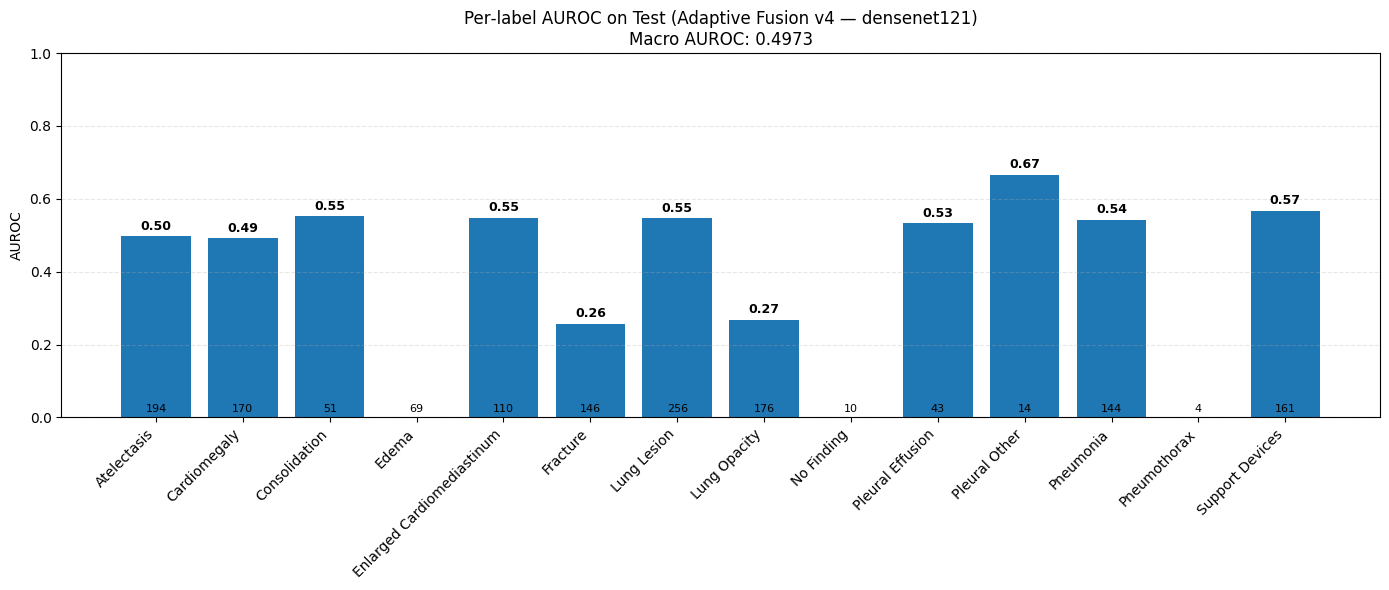

Saved figure → ./fig_per_label_auroc_v4.png


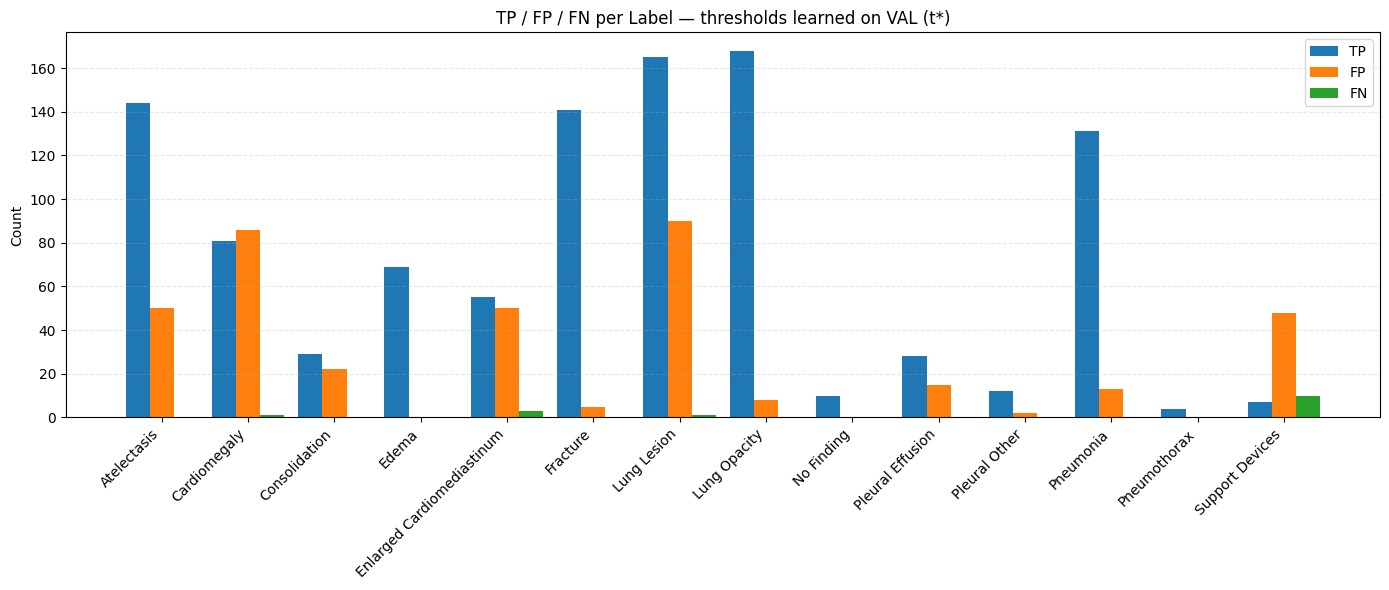

Saved figure → ./fig_tp_fp_fn_v4.png

==== Timing / Memory Summary ====
VAL   forward+sweep: 3.56s | Peak GPU mem: 0.43 GB
TEST  forward+eval : 2.52s | Peak GPU mem: 0.43 GB


In [ ]:
#evaluation|
# eval_with_thresholds_v4.py
import os, time
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
)

from adaptive_fusion_model_v4 import AdaptiveFusionClassifier
from dataloader import get_dataloaders


# -----------------------------
# Config
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = "./checkpoints/adaptive_fusion_v4_densenet121.pt"   
cxr_backbone = "densenet121"                                     
lab_input_dim = 100
batch_size = 16
num_workers = 4
data_dir = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2"

# Threshold search settings
THRESH_METHOD = "f1"   # "f1" or "youden"
N_THRESH = 1001        # grid over [0,1] inclusive

# Outputs
out_thresh_csv   = "./val_optimal_thresholds_v4.csv"
out_metrics_csv  = "./eval_metrics_v4_with_thresh.csv"
out_fig_auroc    = "./fig_per_label_auroc_v4.png"
out_fig_counts   = "./fig_tp_fp_fn_v4.png"
out_fig_rocgrid  = "./fig_roc_grid_v4.png"   # optional
PLOT_ROC_GRID    = False

# CheXpert label names
chexpert_labels = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Enlarged Cardiomediastinum",
    "Fracture", "Lung Lesion", "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]


# -----------------------------
# Data
# -----------------------------
train_loader, val_loader, test_loader = get_dataloaders(
    data_dir, batch_size=batch_size, num_workers=num_workers
)


# -----------------------------
# Model (mirror training hparams)
# -----------------------------
model = AdaptiveFusionClassifier(
    num_classes=14,
    lr=1e-4,
    lab_input_dim=lab_input_dim,
    dropout_prob=0.2,
    cxr_backbone=cxr_backbone,
).to(device)
state = torch.load(checkpoint, map_location=device)
model.load_state_dict(state)
model.eval()
print(f"Loaded checkpoint: {checkpoint}")


def collect_logits(loader):
    """Run model forward and return (probs, targets, gates) as numpy arrays."""
    probs_all, targs_all, gates_all = [], [], []
    with torch.no_grad():
        for cxr, ecg, labs, y in tqdm(loader, desc="Forward pass"):
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            # ECG → (B, 12, T)
            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            logits, gates = model(cxr, ecg, labs, return_gates=True)
            probs = torch.sigmoid(logits)

            probs_all.append(probs.cpu().numpy())
            targs_all.append(y.cpu().numpy())
            gates_all.append(gates.cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(targs_all), np.concatenate(gates_all)


def best_thresholds_from_val(probs, targets, method="f1"):
    """
    Compute a per-label threshold from validation set.
    - method="f1": threshold maximizing F1 on a uniform grid
    - method="youden": threshold maximizing TPR - FPR (Youden's J)
    """
    n_labels = targets.shape[1]
    thresholds = np.full(n_labels, 0.5, dtype=np.float32)
    supports = np.zeros(n_labels, dtype=np.int32)

    for c in range(n_labels):
        y = targets[:, c]
        p = probs[:, c]
        m = (y != -1)
        y = y[m]
        p = p[m]
        supports[c] = y.size

        # Need both classes present
        if y.size == 0 or np.unique(y).size < 2:
            thresholds[c] = 0.5
            continue

        if method == "youden":
            fpr, tpr, thr = roc_curve(y, p)
            j = tpr - fpr
            idx = np.argmax(j)
            thresholds[c] = float(thr[idx])
        else:
            # F1 sweep on a grid
            grid = np.linspace(0.0, 1.0, N_THRESH)
            # Vectorized: compare p[:,None] >= grid[None,:]
            bin_mat = (p[:, None] >= grid[None, :]).astype(np.int32)
            # Compute TP/FP/FN per threshold
            tp = (bin_mat & (y[:, None] == 1)).sum(axis=0)
            fp = (bin_mat & (y[:, None] == 0)).sum(axis=0)
            fn = ((1 - bin_mat) & (y[:, None] == 1)).sum(axis=0)

            precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp) > 0)
            recall    = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) > 0)
            f1        = np.divide(2*precision*recall, precision+recall, out=np.zeros_like(precision, dtype=float), where=(precision+recall) > 0)

            idx = int(np.argmax(f1))
            thresholds[c] = float(grid[idx])

    return thresholds, supports


# -----------------------------
# 1) VAL: threshold search + timing/memory
# -----------------------------
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
t0 = time.perf_counter()

val_probs, val_targets, val_gates = collect_logits(val_loader)
val_elapsed = time.perf_counter() - t0
val_peak_mem_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

thr, val_support = best_thresholds_from_val(val_probs, val_targets, method=THRESH_METHOD)
df_thr = pd.DataFrame({"Label": chexpert_labels, "Threshold": thr, "ValSupport": val_support})
df_thr.to_csv(out_thresh_csv, index=False)
print(f"\nSaved per‑label thresholds ({THRESH_METHOD}) → {out_thresh_csv}")
print(f"VAL sweep time: {val_elapsed:.1f}s | Peak GPU mem: {val_peak_mem_gb:.2f} GB")

# Macro AUROC on VAL (info only)
val_auc_per_label = []
for i in range(len(chexpert_labels)):
    y = val_targets[:, i]; p = val_probs[:, i]
    m = (y != -1)
    if m.sum() > 0 and np.unique(y[m]).size > 1:
        val_auc_per_label.append(roc_auc_score(y[m], p[m]))
    else:
        val_auc_per_label.append(np.nan)
val_macro_auc = np.nanmean(val_auc_per_label)
print(f"VAL Macro AUROC: {val_macro_auc:.4f}")


# -----------------------------
# 2) TEST: evaluation with learned thresholds + timing/memory
# -----------------------------
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
t1 = time.perf_counter()

test_probs, test_targets, test_gates = collect_logits(test_loader)
test_elapsed = time.perf_counter() - t1
test_peak_mem_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

# Per‑label AUROC on test
auroc_per_label = []
sample_counts = []
for i in range(len(chexpert_labels)):
    y = test_targets[:, i]; p = test_probs[:, i]
    m = (y != -1)
    sample_counts.append(int(m.sum()))
    if m.sum() > 0 and np.unique(y[m]).size > 1:
        auroc_per_label.append(roc_auc_score(y[m], p[m]))
    else:
        auroc_per_label.append(np.nan)
macro_auroc = float(np.nanmean([a for a in auroc_per_label if not np.isnan(a)])) if np.any(~np.isnan(auroc_per_label)) else float("nan")

print("Avg gate on TEST → ECG: {:.3f} | CXR: {:.3f} | Labs: {:.3f}".format(
    test_gates[:,0].mean(), test_gates[:,1].mean(), test_gates[:,2].mean()
))
print(f"\nTEST Macro AUROC: {macro_auroc:.4f}")
print(f"TEST eval time: {test_elapsed:.1f}s | Peak GPU mem: {test_peak_mem_gb:.2f} GB")

# Discrete metrics using per‑label thresholds
bin_pred = (test_probs >= thr[None, :]).astype(int)

rows = []
TPs, FPs, FNs = [], [], []
for i, label in enumerate(chexpert_labels):
    y = test_targets[:, i]; p = test_probs[:, i]; h = bin_pred[:, i]
    m = (y != -1)
    y = y[m]; p = p[m]; h = h[m]
    if y.size == 0:
        tp = fp = fn = 0
        precision = recall = f1 = np.nan
        auc = np.nan
        support = 0
    else:
        cm = confusion_matrix(y, h, labels=[0,1])
        if cm.shape == (2,2):
            tn, fp = cm[0]
            fn, tp = cm[1]
        else:
            tp = fp = fn = 0
        support = int(y.size)
        precision = precision_score(y, h, zero_division=0)
        recall    = recall_score(y, h, zero_division=0)
        f1        = f1_score(y, h, zero_division=0)
        try:
            auc = roc_auc_score(y, p) if np.unique(y).size > 1 else np.nan
        except:
            auc = np.nan

    TPs.append(tp); FPs.append(fp); FNs.append(fn)
    rows.append({
        "Label": label, "Support": support,
        "TP": tp, "FP": fp, "FN": fn,
        "Precision@t*": precision, "Recall@t*": recall, "F1@t*": f1,
        "AUROC": auc, "t*": thr[i]
    })

df_metrics = pd.DataFrame(rows).set_index("Label")
df_metrics.loc["Macro", ["AUROC"]] = macro_auroc
df_metrics.to_csv(out_metrics_csv)
print(f"Saved metrics CSV → {out_metrics_csv}")

# -----------------------------
# Plots
# -----------------------------
# 1) AUROC per label
plt.figure(figsize=(14, 6))
bars = plt.bar(chexpert_labels, auroc_per_label)
plt.xticks(rotation=45, ha='right')
plt.ylabel("AUROC")
plt.ylim(0, 1)
plt.title(f"Per‑label AUROC on Test (Adaptive Fusion v4 — {cxr_backbone})\nMacro AUROC: {macro_auroc:.4f}")
for bar, auc, count in zip(bars, auroc_per_label, sample_counts):
    x = bar.get_x() + bar.get_width()/2
    h = 0 if np.isnan(auc) else auc
    if not np.isnan(auc):
        plt.text(x, h + 0.01, f"{auc:.2f}", ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.text(x, 0.01, f"{count}", ha='center', va='bottom', fontsize=8)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(out_fig_auroc, dpi=180)
plt.show()
print(f"Saved figure → {out_fig_auroc}")

# 2) TP / FP / FN bars at learned thresholds
x = np.arange(len(chexpert_labels))
bw = 0.28
plt.figure(figsize=(14, 6))
plt.bar(x - bw, TPs, width=bw, label='TP')
plt.bar(x,       FPs, width=bw, label='FP')
plt.bar(x + bw,  FNs, width=bw, label='FN')
plt.xticks(x, chexpert_labels, rotation=45, ha='right')
plt.ylabel("Count")
plt.title("TP / FP / FN per Label — thresholds learned on VAL (t*)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(out_fig_counts, dpi=180)
plt.show()
print(f"Saved figure → {out_fig_counts}")

# 3) (optional) ROC grid
if PLOT_ROC_GRID:
    n_cols = 4
    n_rows = int(np.ceil(len(chexpert_labels) / n_cols))
    plt.figure(figsize=(4*n_cols, 3.5*n_rows))
    for i, label in enumerate(chexpert_labels):
        y = test_targets[:, i]; p = test_probs[:, i]
        m = (y != -1); y = y[m]; p = p[m]
        plt.subplot(n_rows, n_cols, i+1)
        if y.size > 0 and np.unique(y).size > 1:
            fpr, tpr, _ = roc_curve(y, p)
            auc = roc_auc_score(y, p)
            plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
        else:
            plt.text(0.5, 0.5, "N/A", ha='center', va='center')
        plt.title(label, fontsize=10)
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.xlim(0, 1); plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(out_fig_rocgrid, dpi=180)
    plt.show()
    print(f"Saved figure → {out_fig_rocgrid}")

# -----------------------------
# Timing & memory summary
# -----------------------------
print("\n==== Timing / Memory Summary ====")
print(f"VAL   forward+sweep: {val_elapsed:.2f}s | Peak GPU mem: {val_peak_mem_gb:.2f} GB")
print(f"TEST  forward+eval : {test_elapsed:.2f}s | Peak GPU mem: {test_peak_mem_gb:.2f} GB")


In [1]:
# === notebook_backbone_sweep_v4.py  ===
import os, time, random, sys, argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score

from adaptive_fusion_model_v4 import AdaptiveFusionClassifier
from dataloader import get_dataloaders

# add this import (if not already present)
import torch.nn as nn

# --- helper: fully freeze/unfreeze the CXR backbone, including BN stats ---
def set_cxr_frozen(model, freeze: bool):
    # stop/start gradients on all CXR params
    for p in model.cxr_encoder.parameters():
        p.requires_grad = not freeze

    # freeze BN running stats while frozen
    for m in model.cxr_encoder.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.SyncBatchNorm)):
            if freeze:
                m.eval()                     # no running mean/var updates
                m.track_running_stats = False
            else:
                m.train()                    # resume normal BN behavior
                m.track_running_stats = True

    # put the whole encoder in eval when frozen, train when unfrozen
    model.cxr_encoder.train(not freeze)

# -----------------------------
# Utilities
# -----------------------------
def set_global_seed(seed: int = 1337):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def masked_macro_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    C = y_true_np.shape[1]
    scores = []
    for c in range(C):
        m = mask[:, c]
        if m.sum() == 0:
            continue
        yt = y_true_np[m].astype(np.int32)[:, c]
        yp = y_prob_np[m][:, c]
        if yt.max() == yt.min():
            continue
        scores.append(roc_auc_score(yt, yp))
    return float(np.mean(scores)) if scores else float("nan")


def collect_probs_targets(model, loader, device):
    model.eval()
    probs_all, targs_all, gates_all = [], [], []
    with torch.no_grad():
        for cxr, ecg, labs, y in loader:
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            # ECG to (B,12,T)
            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            logits, gates = model(cxr, ecg, labs, return_gates=True)
            probs = torch.sigmoid(logits)

            probs_all.append(probs.cpu().numpy())
            targs_all.append(y.cpu().numpy())
            gates_all.append(gates.cpu().numpy())
    return np.concatenate(probs_all), np.concatenate(targs_all), np.concatenate(gates_all)


# -----------------------------
# Backbone defaults (anti-collapse tuned)
# -----------------------------
BACKBONE_DEFAULTS = {
    "resnet50":        dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1,
                            dropout_prob=0.00, moddrop_warm_epochs=5,
                            gate_init_temp=2.0, gate_min_temp=1.0, gate_anneal=0.999,
                            lambda_gate_entropy=0.000, lambda_gate_diversity=0.00),
    "densenet121":     dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1,
                            dropout_prob=0.0, moddrop_warm_epochs=5,
                            gate_init_temp=2.0, gate_min_temp=1.0, gate_anneal=0.999,
                            lambda_gate_entropy=0.000, lambda_gate_diversity=0.000),
    "efficientnet_b2": dict(backbone_lr_scale=0.05, freeze_cxr_epochs=2,
                            dropout_prob=0.0, moddrop_warm_epochs=7,
                            gate_init_temp=2.2, gate_min_temp=1.0, gate_anneal=0.999,
                            lambda_gate_entropy=0.00, lambda_gate_diversity=0.000),
    "convnext_tiny":   dict(backbone_lr_scale=0.08, freeze_cxr_epochs=2,
                            dropout_prob=0.00, moddrop_warm_epochs=7,
                            gate_init_temp=2.2, gate_min_temp=1.0, gate_anneal=0.999,
                            lambda_gate_entropy=0.00, lambda_gate_diversity=0.00),
    "vgg16_bn":        dict(backbone_lr_scale=0.30, freeze_cxr_epochs=1,
                            dropout_prob=0.00, moddrop_warm_epochs=5,
                            gate_init_temp=2.0, gate_min_temp=1.0, gate_anneal=0.999,
                            lambda_gate_entropy=0.000, lambda_gate_diversity=0.000),
}

SUPPORTED_BACKBONES = set(BACKBONE_DEFAULTS.keys())


# -----------------------------
# Train one backbone
# -----------------------------
def train_one_backbone(
    cxr_backbone: str,
    data_dir: str,
    save_dir: str,
    device,
    n_epochs=30,
    batch_size=16,
    num_workers=4,
    lr=1e-4,
    weight_decay=1e-5,
    lab_input_dim=100,
    use_amp=True,
    use_ema=False,
    # overrides (None → use defaults)
    dropout_prob=None,
    moddrop_warm_epochs=None,
    gate_init_temp=None,
    gate_min_temp=None,
    gate_anneal=None,
    lambda_gate_entropy=None,
    lambda_gate_diversity=None,
    backbone_lr_scale=None,
    freeze_cxr_epochs=None,
):
    if cxr_backbone not in SUPPORTED_BACKBONES:
        raise ValueError(f"Backbone '{cxr_backbone}' not supported. Choose from {sorted(SUPPORTED_BACKBONES)}.")

    os.makedirs(save_dir, exist_ok=True)
    gates_csv = os.path.join(save_dir, f"gate_trends_{cxr_backbone}.csv")
    ckpt_path = os.path.join(save_dir, f"adaptive_fusion_v4_{cxr_backbone}.pt")

    # ---- merge defaults with overrides ----
    cfg = {**BACKBONE_DEFAULTS[cxr_backbone]}
    if dropout_prob            is not None: cfg["dropout_prob"] = dropout_prob
    if moddrop_warm_epochs     is not None: cfg["moddrop_warm_epochs"] = moddrop_warm_epochs
    if gate_init_temp          is not None: cfg["gate_init_temp"] = gate_init_temp
    if gate_min_temp           is not None: cfg["gate_min_temp"] = gate_min_temp
    if gate_anneal             is not None: cfg["gate_anneal"] = gate_anneal
    if lambda_gate_entropy     is not None: cfg["lambda_gate_entropy"] = lambda_gate_entropy
    if lambda_gate_diversity   is not None: cfg["lambda_gate_diversity"] = lambda_gate_diversity
    if backbone_lr_scale       is not None: cfg["backbone_lr_scale"] = backbone_lr_scale
    if freeze_cxr_epochs       is not None: cfg["freeze_cxr_epochs"] = freeze_cxr_epochs

    # ---- data ----
    train_loader, val_loader, test_loader = get_dataloaders(
        data_dir, batch_size=batch_size, num_workers=num_workers
    )

    # ---- model ----
    model = AdaptiveFusionClassifier(
        num_classes=14,
        lr=lr,
        lab_input_dim=lab_input_dim,
        dropout_prob=cfg["dropout_prob"],
        cxr_backbone=cxr_backbone,
        moddrop_warm_epochs=cfg["moddrop_warm_epochs"],
        gate_init_temp=cfg["gate_init_temp"],
        gate_min_temp=cfg["gate_min_temp"],
        gate_anneal=cfg["gate_anneal"],
        lambda_gate_entropy=cfg["lambda_gate_entropy"],
        lambda_gate_diversity=cfg["lambda_gate_diversity"],
        normalization="none",
    ).to(device)

    # ---- optimizer with smaller LR for backbone ----
    backbone_params = list(model.cxr_encoder.parameters())
    other_params = [p for n, p in model.named_parameters()
                    if p.requires_grad and not n.startswith("cxr_encoder.")]

    optimizer = torch.optim.Adam(
        [{"params": other_params,   "lr": lr},
         {"params": backbone_params, "lr": lr * cfg["backbone_lr_scale"]}],
        weight_decay=weight_decay
    )
    BACKBONE_GROUP_IDX = 1

    scaler = GradScaler(device="cuda", enabled=(use_amp and torch.cuda.is_available()))

    # ---- optional EMA ----
    ema = None
    if use_ema:
        class EMA:
            def __init__(self, model, decay=0.999):
                self.decay = decay
                self.shadow = {n: p.detach().clone()
                               for n, p in model.named_parameters() if p.requires_grad}
            @torch.no_grad()
            def update(self, model):
                for n, p in model.named_parameters():
                    if p.requires_grad:
                        self.shadow[n].mul_((self.decay)).add_(p.detach(), alpha=1-self.decay)
            @torch.no_grad()
            def apply_to(self, model):
                self._backup = {}
                for n, p in model.named_parameters():
                    if p.requires_grad:
                        self._backup[n] = p.detach().clone()
                        p.copy_(self.shadow[n])
            @torch.no_grad()
            def restore(self, model):
                for n, p in model.named_parameters():
                    if p.requires_grad and n in self._backup:
                        p.copy_(self._backup[n])
                self._backup = {}
        ema = EMA(model, decay=0.999)

    gate_stats = []
    best_val_auroc = -1.0
    total_train_sec = 0.0
    peak_gpu_overall = 0.0

    # ---- training loop ----
    for epoch in range(n_epochs):
        model.train()
        model.set_epoch(epoch)  # drives dropout anneal

        # extra smooth gates for first 2 epochs
        if epoch < 2:
            with torch.no_grad():
                model.fusion.temperature.fill_(max(model.hparams.gate_init_temp, 2.0))

        # temporarily freeze CXR backbone to avoid instant dominance
        # hard-freeze the CXR backbone (params + BN stats) during the freeze window
        freeze_now = epoch < int(cfg["freeze_cxr_epochs"])
        set_cxr_frozen(model, freeze_now)
        optimizer.param_groups[BACKBONE_GROUP_IDX]["lr"] = (
            0.0 if freeze_now else lr * cfg["backbone_lr_scale"]
)


        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()
        ep_t0 = time.perf_counter()

        train_loss_sum = 0.0
        y_true_train, y_prob_train = [], []

        for cxr, ecg, labs, y in tqdm(train_loader, desc=f"[{cxr_backbone}] Train {epoch+1}/{n_epochs}", leave=False):
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=(use_amp and torch.cuda.is_available())):
                logits, gates = model(cxr, ecg, labs, return_gates=True)
                bce = model.masked_bce_loss(logits, y)

                # Replace the loss computation block inside the train loop:
                eps = 1e-8
                entropy   = (-(gates * (gates + eps).log()).sum(dim=1)).mean()  # encourage ↑
                batch_var = gates.var(dim=0).mean()                             # encourage ↑
                loss = bce - model.hparams.lambda_gate_entropy * entropy \
                        - model.hparams.lambda_gate_diversity * batch_var

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                model.fusion.step_temperature()

            train_loss_sum += float(loss.item())
            with torch.no_grad():
                y_prob_train.append(torch.sigmoid(logits).cpu().numpy())
                y_true_train.append(y.cpu().numpy())

            if ema is not None:
                ema.update(model)

        y_prob_train = np.concatenate(y_prob_train)
        y_true_train = np.concatenate(y_true_train)
        train_auroc = masked_macro_auroc(y_true_train, y_prob_train)
        avg_train_loss = train_loss_sum / max(1, len(train_loader))

        # ---- validation (EMA swap if used) ----
        if ema is not None:
            ema.apply_to(model)

        model.eval()
        val_loss_sum = 0.0
        y_true_val, y_prob_val = [], []
        all_gates_val = []

        with torch.no_grad():
            for cxr, ecg, labs, y in tqdm(val_loader, desc=f"[{cxr_backbone}] Val {epoch+1}/{n_epochs}", leave=False):
                cxr  = cxr.to(device).float()
                labs = labs.to(device).float()
                y    = y.to(device)

                ecg = ecg.to(device).float()
                if ecg.ndim == 4 and ecg.shape[1] == 1:
                    ecg = ecg.squeeze(1)
                if ecg.shape[1] != 12 and ecg.shape[-1] == 12:
                    ecg = ecg.permute(0, 2, 1)

                logits, gates = model(cxr, ecg, labs, return_gates=True)
                loss = model.masked_bce_loss(logits, y)
                val_loss_sum += float(loss.item())

                y_prob_val.append(torch.sigmoid(logits).cpu().numpy())
                y_true_val.append(y.cpu().numpy())
                all_gates_val.append(gates.cpu().numpy())

        if ema is not None:
            ema.restore(model)

        def masked_flat_auroc(y_true_np, y_prob_np):
            mask = (y_true_np != -1)
            yt = y_true_np[mask].astype(np.int32)
            yp = y_prob_np[mask]
            return float(roc_auc_score(yt, yp))


        y_prob_val   = np.concatenate(y_prob_val)
        y_true_val   = np.concatenate(y_true_val)
        all_gates_val= np.concatenate(all_gates_val)

        val_auroc_macro = masked_macro_auroc(y_true_val, y_prob_val)
        val_auroc_flat  = masked_flat_auroc(y_true_val, y_prob_val)

        gate_ecg  = float(all_gates_val[:, 0].mean())
        gate_cxr  = float(all_gates_val[:, 1].mean())
        gate_labs = float(all_gates_val[:, 2].mean())

        ep_time = time.perf_counter() - ep_t0
        total_train_sec += ep_time
        peak_mem_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0
        peak_gpu_overall = max(peak_gpu_overall, peak_mem_gb)

        print(f"[{cxr_backbone}] Epoch {epoch+1}/{n_epochs} | "
                f"TrainLoss {avg_train_loss:.4f} | TrainAUC {train_auroc:.4f} | "
                f"ValLoss {val_loss_sum/len(val_loader):.4f} | "
                f"ValAUC_macro {val_auroc_macro:.4f} | ValAUC_flat {val_auroc_flat:.4f} | "
                f"Gates(E,C,L) {gate_ecg:.3f},{gate_cxr:.3f},{gate_labs:.3f} | "
                f"{ep_time:.1f}s | Peak {peak_mem_gb:.2f} GB")

        if val_auroc_macro > best_val_auroc:
            best_val_auroc = val_auroc_macro
            torch.save(model.state_dict(), ckpt_path)
            print(f"  Saved best @ epoch {epoch+1}: {best_val_auroc:.4f} → {ckpt_path}")


        gate_stats.append({
            "epoch": epoch+1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss_sum/len(val_loader),
            "train_auroc_macro": train_auroc,
            "val_auroc_macro": val_auroc_macro,
            "val_auroc_flat": val_auroc_flat,   # <-- new
            "gate_ecg": gate_ecg,
            "gate_cxr": gate_cxr,
            "gate_labs": gate_labs,
            "epoch_sec": ep_time,
            "peak_mem_GB": peak_mem_gb,
        })
        pd.DataFrame(gate_stats).to_csv(gates_csv, index=False)

    # --- After training: Test evaluation timing ---
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    t0 = time.perf_counter()
    _, _, test_loader = get_dataloaders(data_dir, batch_size=batch_size, num_workers=num_workers)
    test_probs, test_targets, test_gates = collect_probs_targets(model, test_loader, device)
    test_elapsed = time.perf_counter() - t0
    test_peak_gb = (torch.cuda.max_memory_allocated() / 1e9) if torch.cuda.is_available() else 0.0

    test_macro = masked_macro_auroc(test_targets, test_probs)
    test_flat  = masked_flat_auroc(test_targets, test_probs)
    gate_test = test_gates.mean(axis=0).tolist()

    return {
        "backbone": cxr_backbone,
        "best_val_macro_auc": float(best_val_auroc),
        "test_macro_auc": float(test_macro),
        "test_flat_auc": float(test_flat),     # <-- NEW
        "train_total_sec": float(total_train_sec),
        "train_avg_epoch_sec": float(total_train_sec / max(1, len(gate_stats))),
        "train_peak_gpu_GB": float(peak_gpu_overall),
        "test_eval_sec": float(test_elapsed),
        "test_peak_gpu_GB": float(test_peak_gb),
        "test_gate_ecg": float(gate_test[0]),
        "test_gate_cxr": float(gate_test[1]),
        "test_gate_labs": float(gate_test[2]),
        "checkpoint": os.path.abspath(ckpt_path),
        "gate_trends_csv": os.path.abspath(gates_csv)
    }





def run_backbone_sweep(
    data_dir,
    save_dir="./checkpoints",
    backbones=("resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"),
    epochs=30,
    batch_size=16,
    num_workers=4,
    seed=1337,
    overrides=None,  # dict[str, dict]
):
    set_global_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(save_dir, exist_ok=True)

    summary = []
    for b in backbones:
        if b not in SUPPORTED_BACKBONES:
            print(f"[skip] Backbone '{b}' not supported; choose from {sorted(SUPPORTED_BACKBONES)}")
            continue
        print("\n" + "="*80)
        print(f"Training backbone: {b}")
        print("="*80)

        kw = (overrides or {}).get(b, {})
        res = train_one_backbone(
            cxr_backbone=b,
            data_dir=data_dir,
            save_dir=save_dir,
            device=device,
            n_epochs=epochs,
            batch_size=batch_size,
            num_workers=num_workers,
            **kw,
        )
        summary.append(res)

    df = pd.DataFrame(summary)
    out_csv = os.path.join(save_dir, "backbone_sweep_summary.csv")
    df.to_csv(out_csv, index=False)
    print("\n=== Sweep Summary ===")
    if not df.empty:
        print(df.to_string(index=False))
        print(f"\nSaved summary → {out_csv}")
    else:
        print("No runs executed (empty).")
    return df


# -----------------------------
# Optional CLI entry (safe for Jupyter)
# -----------------------------
def _cli():
    ap = argparse.ArgumentParser()
    ap.add_argument("--data_dir", type=str, default="/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2")
    ap.add_argument("--save_dir", type=str, default="./checkpoints")
    ap.add_argument("--backbones", type=str, nargs="+",
                    default=["resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"])
    ap.add_argument("--epochs", type=int, default=30)
    ap.add_argument("--batch_size", type=int, default=16)
    ap.add_argument("--num_workers", type=int, default=4)
    ap.add_argument("--seed", type=int, default=1337)
    # ignore Jupyter's extra args like --f=...
    args, _unknown = ap.parse_known_args(sys.argv[1:])

    run_backbone_sweep(
        data_dir=args.data_dir,
        save_dir=args.save_dir,
        backbones=args.backbones,
        epochs=args.epochs,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        seed=args.seed,
        overrides=None,   # or pass a dict like {"resnet50": {"freeze_cxr_epochs": 2}}
    )


if __name__ == "__main__":
    _cli()


/data/mahjabeen_workspace/Summer25_Project/symile/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Training backbone: resnet50


[resnet50] Epoch 1/30 | TrainLoss 0.4525 | TrainAUC 0.4761 | ValLoss 0.4308 | ValAUC_macro 0.4870 | ValAUC_flat 0.8426 | Gates(E,C,L) 0.345,0.356,0.300 | 25.0s | Peak 0.48 GB
  Saved best @ epoch 1: 0.4870 → ./checkpoints/adaptive_fusion_v4_resnet50.pt


[resnet50] Epoch 2/30 | TrainLoss 0.4417 | TrainAUC 0.5046 | ValLoss 0.4333 | ValAUC_macro 0.5229 | ValAUC_flat 0.8485 | Gates(E,C,L) 0.411,0.266,0.323 | 45.3s | Peak 1.85 GB
  Saved best @ epoch 2: 0.5229 → ./checkpoints/adaptive_fusion_v4_resnet50.pt


[resnet50] Epoch 3/30 | TrainLoss 0.4352 | TrainAUC 0.5158 | ValLoss 0.4288 | ValAUC_macro 0.5451 | ValAUC_flat 0.8448 | Gates(E,C,L) 0.490,0.172,0.338 | 45.3s | Peak 1.85 GB
  Saved best @ epoch 3: 0.5451 → ./checkpoints/adaptive_fusion_v4_resnet50.pt


[resnet50] Epoch 4/30 | TrainLoss 0.4300 | TrainAUC 0.5535 | ValLoss 0.4280 | ValAUC_macro 0.5387 | ValAUC_flat 0.8456 | Gates(E,C,L) 0.513,0.137,0.350 | 45.6s | Peak 1.85 GB


[resnet50] Epoch 5/30 | TrainLoss 0.4221 | TrainAUC 0.6227 | ValLoss 0.4275 | ValAUC_macro 0.5180 | ValAUC_flat 0.8467 | Gates(E,C,L) 0.431,0.155,0.414 | 45.7s | Peak 1.85 GB


[resnet50] Epoch 6/30 | TrainLoss 0.3964 | TrainAUC 0.7442 | ValLoss 0.4490 | ValAUC_macro 0.4942 | ValAUC_flat 0.8360 | Gates(E,C,L) 0.403,0.123,0.473 | 46.2s | Peak 1.85 GB


[resnet50] Epoch 7/30 | TrainLoss 0.3530 | TrainAUC 0.8138 | ValLoss 0.5652 | ValAUC_macro 0.4816 | ValAUC_flat 0.8370 | Gates(E,C,L) 0.383,0.054,0.562 | 45.5s | Peak 1.85 GB


[resnet50] Epoch 8/30 | TrainLoss 0.2978 | TrainAUC 0.8765 | ValLoss 0.5058 | ValAUC_macro 0.5416 | ValAUC_flat 0.8172 | Gates(E,C,L) 0.354,0.131,0.515 | 45.5s | Peak 1.85 GB


[resnet50] Epoch 9/30 | TrainLoss 0.2527 | TrainAUC 0.8971 | ValLoss 0.6352 | ValAUC_macro 0.5233 | ValAUC_flat 0.8229 | Gates(E,C,L) 0.343,0.084,0.573 | 45.4s | Peak 1.85 GB


[resnet50] Epoch 10/30 | TrainLoss 0.2238 | TrainAUC 0.9229 | ValLoss 0.8141 | ValAUC_macro 0.4890 | ValAUC_flat 0.7774 | Gates(E,C,L) 0.310,0.103,0.587 | 45.2s | Peak 1.85 GB


[resnet50] Epoch 11/30 | TrainLoss 0.1899 | TrainAUC 0.9344 | ValLoss 0.7555 | ValAUC_macro 0.5206 | ValAUC_flat 0.8210 | Gates(E,C,L) 0.229,0.070,0.701 | 45.2s | Peak 1.85 GB


[resnet50] Epoch 12/30 | TrainLoss 0.1750 | TrainAUC 0.9465 | ValLoss 1.0147 | ValAUC_macro 0.5248 | ValAUC_flat 0.7944 | Gates(E,C,L) 0.262,0.080,0.658 | 45.3s | Peak 1.85 GB


[resnet50] Epoch 13/30 | TrainLoss 0.1533 | TrainAUC 0.9543 | ValLoss 1.2460 | ValAUC_macro 0.5155 | ValAUC_flat 0.8183 | Gates(E,C,L) 0.128,0.026,0.846 | 45.2s | Peak 1.85 GB


[resnet50] Epoch 14/30 | TrainLoss 0.1281 | TrainAUC 0.9611 | ValLoss 1.2755 | ValAUC_macro 0.5462 | ValAUC_flat 0.7961 | Gates(E,C,L) 0.184,0.098,0.718 | 45.2s | Peak 1.85 GB
  Saved best @ epoch 14: 0.5462 → ./checkpoints/adaptive_fusion_v4_resnet50.pt


[resnet50] Epoch 15/30 | TrainLoss 0.1198 | TrainAUC 0.9671 | ValLoss 1.1329 | ValAUC_macro 0.5041 | ValAUC_flat 0.7725 | Gates(E,C,L) 0.192,0.138,0.670 | 45.4s | Peak 1.85 GB


[resnet50] Epoch 16/30 | TrainLoss 0.1087 | TrainAUC 0.9697 | ValLoss 1.4788 | ValAUC_macro 0.5122 | ValAUC_flat 0.7656 | Gates(E,C,L) 0.185,0.120,0.695 | 45.0s | Peak 1.85 GB


[resnet50] Epoch 17/30 | TrainLoss 0.0984 | TrainAUC 0.9774 | ValLoss 1.1598 | ValAUC_macro 0.4882 | ValAUC_flat 0.7791 | Gates(E,C,L) 0.151,0.192,0.657 | 45.2s | Peak 1.85 GB


[resnet50] Epoch 18/30 | TrainLoss 0.0915 | TrainAUC 0.9754 | ValLoss 1.4102 | ValAUC_macro 0.5064 | ValAUC_flat 0.7578 | Gates(E,C,L) 0.143,0.131,0.726 | 45.1s | Peak 1.85 GB


[resnet50] Epoch 19/30 | TrainLoss 0.0936 | TrainAUC 0.9740 | ValLoss 1.0292 | ValAUC_macro 0.5111 | ValAUC_flat 0.7893 | Gates(E,C,L) 0.149,0.214,0.636 | 45.4s | Peak 1.85 GB


[resnet50] Epoch 20/30 | TrainLoss 0.0836 | TrainAUC 0.9827 | ValLoss 1.4908 | ValAUC_macro 0.5173 | ValAUC_flat 0.8123 | Gates(E,C,L) 0.151,0.026,0.824 | 45.3s | Peak 1.85 GB


[resnet50] Epoch 21/30 | TrainLoss 0.0760 | TrainAUC 0.9837 | ValLoss 1.0138 | ValAUC_macro 0.5115 | ValAUC_flat 0.7934 | Gates(E,C,L) 0.220,0.148,0.632 | 45.1s | Peak 1.85 GB


[resnet50] Epoch 22/30 | TrainLoss 0.0772 | TrainAUC 0.9856 | ValLoss 0.9435 | ValAUC_macro 0.5487 | ValAUC_flat 0.7245 | Gates(E,C,L) 0.176,0.314,0.511 | 45.3s | Peak 1.85 GB
  Saved best @ epoch 22: 0.5487 → ./checkpoints/adaptive_fusion_v4_resnet50.pt


[resnet50] Epoch 23/30 | TrainLoss 0.0672 | TrainAUC 0.9870 | ValLoss 1.0629 | ValAUC_macro 0.5135 | ValAUC_flat 0.7933 | Gates(E,C,L) 0.180,0.202,0.618 | 45.3s | Peak 1.85 GB


[resnet50] Epoch 24/30 | TrainLoss 0.0661 | TrainAUC 0.9886 | ValLoss 1.6303 | ValAUC_macro 0.4426 | ValAUC_flat 0.7723 | Gates(E,C,L) 0.113,0.241,0.646 | 45.3s | Peak 1.85 GB


[resnet50] Epoch 25/30 | TrainLoss 0.0646 | TrainAUC 0.9893 | ValLoss 1.4795 | ValAUC_macro 0.4689 | ValAUC_flat 0.7440 | Gates(E,C,L) 0.218,0.144,0.638 | 45.3s | Peak 1.85 GB


[resnet50] Epoch 26/30 | TrainLoss 0.0623 | TrainAUC 0.9903 | ValLoss 1.0477 | ValAUC_macro 0.5146 | ValAUC_flat 0.8013 | Gates(E,C,L) 0.272,0.078,0.650 | 45.3s | Peak 1.85 GB


[resnet50] Epoch 27/30 | TrainLoss 0.0563 | TrainAUC 0.9919 | ValLoss 1.2224 | ValAUC_macro 0.5137 | ValAUC_flat 0.7775 | Gates(E,C,L) 0.171,0.260,0.569 | 45.2s | Peak 1.85 GB


[resnet50] Epoch 28/30 | TrainLoss 0.0559 | TrainAUC 0.9924 | ValLoss 1.1017 | ValAUC_macro 0.5409 | ValAUC_flat 0.8013 | Gates(E,C,L) 0.294,0.123,0.584 | 45.4s | Peak 1.85 GB


[resnet50] Epoch 29/30 | TrainLoss 0.0554 | TrainAUC 0.9922 | ValLoss 1.1544 | ValAUC_macro 0.4479 | ValAUC_flat 0.7958 | Gates(E,C,L) 0.210,0.174,0.616 | 45.2s | Peak 1.85 GB


[resnet50] Epoch 30/30 | TrainLoss 0.0530 | TrainAUC 0.9896 | ValLoss 1.4905 | ValAUC_macro 0.5363 | ValAUC_flat 0.7925 | Gates(E,C,L) 0.272,0.089,0.639 | 45.5s | Peak 1.85 GB

Training backbone: densenet121


[densenet121] Epoch 1/30 | TrainLoss 0.4590 | TrainAUC 0.5009 | ValLoss 0.4304 | ValAUC_macro 0.5445 | ValAUC_flat 0.8463 | Gates(E,C,L) 0.232,0.538,0.229 | 26.4s | Peak 0.60 GB
  Saved best @ epoch 1: 0.5445 → ./checkpoints/adaptive_fusion_v4_densenet121.pt


[densenet121] Epoch 2/30 | TrainLoss 0.4381 | TrainAUC 0.5096 | ValLoss 0.4357 | ValAUC_macro 0.5374 | ValAUC_flat 0.8422 | Gates(E,C,L) 0.324,0.357,0.319 | 54.2s | Peak 2.54 GB


[densenet121] Epoch 3/30 | TrainLoss 0.4341 | TrainAUC 0.5280 | ValLoss 0.4286 | ValAUC_macro 0.5574 | ValAUC_flat 0.8464 | Gates(E,C,L) 0.333,0.338,0.329 | 54.1s | Peak 2.35 GB
  Saved best @ epoch 3: 0.5574 → ./checkpoints/adaptive_fusion_v4_densenet121.pt


[densenet121] Epoch 4/30 | TrainLoss 0.4301 | TrainAUC 0.5527 | ValLoss 0.4294 | ValAUC_macro 0.5472 | ValAUC_flat 0.8449 | Gates(E,C,L) 0.338,0.330,0.332 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 5/30 | TrainLoss 0.4220 | TrainAUC 0.6295 | ValLoss 0.4262 | ValAUC_macro 0.5715 | ValAUC_flat 0.8489 | Gates(E,C,L) 0.335,0.328,0.337 | 54.3s | Peak 2.35 GB
  Saved best @ epoch 5: 0.5715 → ./checkpoints/adaptive_fusion_v4_densenet121.pt


[densenet121] Epoch 6/30 | TrainLoss 0.4025 | TrainAUC 0.7213 | ValLoss 0.4405 | ValAUC_macro 0.5332 | ValAUC_flat 0.8447 | Gates(E,C,L) 0.324,0.346,0.331 | 53.8s | Peak 2.35 GB


[densenet121] Epoch 7/30 | TrainLoss 0.3693 | TrainAUC 0.7908 | ValLoss 0.4532 | ValAUC_macro 0.4722 | ValAUC_flat 0.8432 | Gates(E,C,L) 0.290,0.393,0.318 | 54.1s | Peak 2.35 GB


[densenet121] Epoch 8/30 | TrainLoss 0.3278 | TrainAUC 0.8415 | ValLoss 0.4753 | ValAUC_macro 0.5442 | ValAUC_flat 0.8432 | Gates(E,C,L) 0.206,0.535,0.259 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 9/30 | TrainLoss 0.2895 | TrainAUC 0.8827 | ValLoss 0.5483 | ValAUC_macro 0.5293 | ValAUC_flat 0.8192 | Gates(E,C,L) 0.143,0.659,0.199 | 54.0s | Peak 2.35 GB


[densenet121] Epoch 10/30 | TrainLoss 0.2514 | TrainAUC 0.9043 | ValLoss 0.6235 | ValAUC_macro 0.4706 | ValAUC_flat 0.8338 | Gates(E,C,L) 0.040,0.886,0.075 | 54.5s | Peak 2.35 GB


[densenet121] Epoch 11/30 | TrainLoss 0.2201 | TrainAUC 0.9288 | ValLoss 0.8105 | ValAUC_macro 0.5047 | ValAUC_flat 0.8378 | Gates(E,C,L) 0.007,0.975,0.018 | 53.9s | Peak 2.35 GB


[densenet121] Epoch 12/30 | TrainLoss 0.1978 | TrainAUC 0.9361 | ValLoss 0.9831 | ValAUC_macro 0.5045 | ValAUC_flat 0.8147 | Gates(E,C,L) 0.002,0.991,0.007 | 54.4s | Peak 2.35 GB


[densenet121] Epoch 13/30 | TrainLoss 0.1818 | TrainAUC 0.9467 | ValLoss 0.6683 | ValAUC_macro 0.5445 | ValAUC_flat 0.8236 | Gates(E,C,L) 0.007,0.978,0.015 | 54.2s | Peak 2.35 GB


[densenet121] Epoch 14/30 | TrainLoss 0.1720 | TrainAUC 0.9476 | ValLoss 0.8890 | ValAUC_macro 0.4784 | ValAUC_flat 0.8240 | Gates(E,C,L) 0.002,0.994,0.004 | 54.2s | Peak 2.35 GB


[densenet121] Epoch 15/30 | TrainLoss 0.1546 | TrainAUC 0.9610 | ValLoss 1.1531 | ValAUC_macro 0.4894 | ValAUC_flat 0.8354 | Gates(E,C,L) 0.000,1.000,0.000 | 54.4s | Peak 2.35 GB


[densenet121] Epoch 16/30 | TrainLoss 0.1414 | TrainAUC 0.9602 | ValLoss 0.7959 | ValAUC_macro 0.4949 | ValAUC_flat 0.7160 | Gates(E,C,L) 0.035,0.916,0.049 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 17/30 | TrainLoss 0.1255 | TrainAUC 0.9702 | ValLoss 1.4932 | ValAUC_macro 0.5456 | ValAUC_flat 0.7914 | Gates(E,C,L) 0.000,1.000,0.000 | 54.9s | Peak 2.35 GB


[densenet121] Epoch 18/30 | TrainLoss 0.1122 | TrainAUC 0.9734 | ValLoss 2.2876 | ValAUC_macro 0.5206 | ValAUC_flat 0.8272 | Gates(E,C,L) 0.000,1.000,0.000 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 19/30 | TrainLoss 0.1024 | TrainAUC 0.9757 | ValLoss 1.3399 | ValAUC_macro 0.5201 | ValAUC_flat 0.8267 | Gates(E,C,L) 0.000,0.999,0.001 | 54.2s | Peak 2.35 GB


[densenet121] Epoch 20/30 | TrainLoss 0.0881 | TrainAUC 0.9798 | ValLoss 1.4994 | ValAUC_macro 0.4901 | ValAUC_flat 0.8154 | Gates(E,C,L) 0.000,1.000,0.000 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 21/30 | TrainLoss 0.0851 | TrainAUC 0.9807 | ValLoss 1.1590 | ValAUC_macro 0.5278 | ValAUC_flat 0.8206 | Gates(E,C,L) 0.001,0.998,0.001 | 54.1s | Peak 2.35 GB


[densenet121] Epoch 22/30 | TrainLoss 0.0781 | TrainAUC 0.9841 | ValLoss 1.2081 | ValAUC_macro 0.4616 | ValAUC_flat 0.7910 | Gates(E,C,L) 0.002,0.994,0.004 | 54.4s | Peak 2.35 GB


[densenet121] Epoch 23/30 | TrainLoss 0.0685 | TrainAUC 0.9855 | ValLoss 1.1196 | ValAUC_macro 0.4524 | ValAUC_flat 0.8013 | Gates(E,C,L) 0.000,1.000,0.000 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 24/30 | TrainLoss 0.0663 | TrainAUC 0.9884 | ValLoss 1.5832 | ValAUC_macro 0.5269 | ValAUC_flat 0.8050 | Gates(E,C,L) 0.000,0.999,0.001 | 54.4s | Peak 2.35 GB


[densenet121] Epoch 25/30 | TrainLoss 0.0603 | TrainAUC 0.9880 | ValLoss 1.1482 | ValAUC_macro 0.5436 | ValAUC_flat 0.7712 | Gates(E,C,L) 0.000,1.000,0.000 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 26/30 | TrainLoss 0.0517 | TrainAUC 0.9909 | ValLoss 1.7295 | ValAUC_macro 0.5037 | ValAUC_flat 0.8137 | Gates(E,C,L) 0.000,1.000,0.000 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 27/30 | TrainLoss 0.0492 | TrainAUC 0.9927 | ValLoss 1.3747 | ValAUC_macro 0.5363 | ValAUC_flat 0.8016 | Gates(E,C,L) 0.000,1.000,0.000 | 54.5s | Peak 2.35 GB


[densenet121] Epoch 28/30 | TrainLoss 0.0482 | TrainAUC 0.9934 | ValLoss 1.5434 | ValAUC_macro 0.5436 | ValAUC_flat 0.8186 | Gates(E,C,L) 0.000,0.999,0.001 | 54.2s | Peak 2.35 GB


[densenet121] Epoch 29/30 | TrainLoss 0.0435 | TrainAUC 0.9948 | ValLoss 1.1176 | ValAUC_macro 0.5148 | ValAUC_flat 0.7534 | Gates(E,C,L) 0.001,0.998,0.001 | 54.3s | Peak 2.35 GB


[densenet121] Epoch 30/30 | TrainLoss 0.0432 | TrainAUC 0.9951 | ValLoss 1.3902 | ValAUC_macro 0.4782 | ValAUC_flat 0.7175 | Gates(E,C,L) 0.003,0.993,0.004 | 54.5s | Peak 2.35 GB

Training backbone: efficientnet_b2


[efficientnet_b2] Epoch 1/30 | TrainLoss 0.4540 | TrainAUC 0.5166 | ValLoss 0.4353 | ValAUC_macro 0.5088 | ValAUC_flat 0.8432 | Gates(E,C,L) 0.333,0.366,0.302 | 21.8s | Peak 0.48 GB
  Saved best @ epoch 1: 0.5088 → ./checkpoints/adaptive_fusion_v4_efficientnet_b2.pt


[efficientnet_b2] Epoch 2/30 | TrainLoss 0.4365 | TrainAUC 0.4838 | ValLoss 0.4285 | ValAUC_macro 0.4914 | ValAUC_flat 0.8446 | Gates(E,C,L) 0.342,0.344,0.314 | 21.8s | Peak 0.48 GB


[efficientnet_b2] Epoch 3/30 | TrainLoss 0.4467 | TrainAUC 0.5136 | ValLoss 0.4317 | ValAUC_macro 0.5259 | ValAUC_flat 0.8431 | Gates(E,C,L) 0.432,0.205,0.363 | 45.1s | Peak 2.36 GB
  Saved best @ epoch 3: 0.5259 → ./checkpoints/adaptive_fusion_v4_efficientnet_b2.pt


[efficientnet_b2] Epoch 4/30 | TrainLoss 0.4315 | TrainAUC 0.5501 | ValLoss 0.4344 | ValAUC_macro 0.5085 | ValAUC_flat 0.8387 | Gates(E,C,L) 0.410,0.219,0.370 | 45.0s | Peak 2.36 GB


[efficientnet_b2] Epoch 5/30 | TrainLoss 0.4278 | TrainAUC 0.5855 | ValLoss 0.4313 | ValAUC_macro 0.5124 | ValAUC_flat 0.8437 | Gates(E,C,L) 0.371,0.243,0.386 | 45.0s | Peak 2.36 GB


[efficientnet_b2] Epoch 6/30 | TrainLoss 0.4250 | TrainAUC 0.5885 | ValLoss 0.4310 | ValAUC_macro 0.5011 | ValAUC_flat 0.8449 | Gates(E,C,L) 0.353,0.286,0.361 | 45.0s | Peak 2.36 GB


[efficientnet_b2] Epoch 7/30 | TrainLoss 0.4190 | TrainAUC 0.6334 | ValLoss 0.4346 | ValAUC_macro 0.4946 | ValAUC_flat 0.8404 | Gates(E,C,L) 0.316,0.354,0.329 | 45.5s | Peak 2.36 GB


[efficientnet_b2] Epoch 8/30 | TrainLoss 0.4138 | TrainAUC 0.6726 | ValLoss 0.4376 | ValAUC_macro 0.5083 | ValAUC_flat 0.8402 | Gates(E,C,L) 0.232,0.478,0.290 | 45.2s | Peak 2.36 GB


[efficientnet_b2] Epoch 9/30 | TrainLoss 0.4046 | TrainAUC 0.7088 | ValLoss 0.4512 | ValAUC_macro 0.5023 | ValAUC_flat 0.8275 | Gates(E,C,L) 0.111,0.689,0.200 | 45.4s | Peak 2.36 GB


[efficientnet_b2] Epoch 10/30 | TrainLoss 0.3936 | TrainAUC 0.7430 | ValLoss 0.4712 | ValAUC_macro 0.4991 | ValAUC_flat 0.8251 | Gates(E,C,L) 0.043,0.842,0.115 | 45.2s | Peak 2.36 GB


[efficientnet_b2] Epoch 11/30 | TrainLoss 0.3836 | TrainAUC 0.7624 | ValLoss 0.4908 | ValAUC_macro 0.5190 | ValAUC_flat 0.8222 | Gates(E,C,L) 0.016,0.932,0.052 | 45.4s | Peak 2.36 GB


[efficientnet_b2] Epoch 12/30 | TrainLoss 0.3713 | TrainAUC 0.7642 | ValLoss 0.4847 | ValAUC_macro 0.5158 | ValAUC_flat 0.8147 | Gates(E,C,L) 0.016,0.932,0.052 | 45.3s | Peak 2.36 GB


[efficientnet_b2] Epoch 13/30 | TrainLoss 0.3589 | TrainAUC 0.8180 | ValLoss 0.4873 | ValAUC_macro 0.5197 | ValAUC_flat 0.8063 | Gates(E,C,L) 0.015,0.940,0.045 | 44.9s | Peak 2.36 GB


[efficientnet_b2] Epoch 14/30 | TrainLoss 0.3482 | TrainAUC 0.8234 | ValLoss 0.5612 | ValAUC_macro 0.5140 | ValAUC_flat 0.8116 | Gates(E,C,L) 0.003,0.984,0.013 | 45.6s | Peak 2.36 GB


[efficientnet_b2] Epoch 15/30 | TrainLoss 0.3337 | TrainAUC 0.8485 | ValLoss 0.5499 | ValAUC_macro 0.5184 | ValAUC_flat 0.8145 | Gates(E,C,L) 0.002,0.988,0.010 | 45.2s | Peak 2.30 GB


[efficientnet_b2] Epoch 16/30 | TrainLoss 0.3242 | TrainAUC 0.8368 | ValLoss 0.5599 | ValAUC_macro 0.5169 | ValAUC_flat 0.7956 | Gates(E,C,L) 0.003,0.984,0.014 | 45.6s | Peak 2.30 GB


[efficientnet_b2] Epoch 17/30 | TrainLoss 0.3123 | TrainAUC 0.8679 | ValLoss 0.5264 | ValAUC_macro 0.4852 | ValAUC_flat 0.8047 | Gates(E,C,L) 0.002,0.989,0.009 | 45.3s | Peak 2.30 GB


[efficientnet_b2] Epoch 18/30 | TrainLoss 0.3002 | TrainAUC 0.8715 | ValLoss 0.5717 | ValAUC_macro 0.4958 | ValAUC_flat 0.7921 | Gates(E,C,L) 0.001,0.994,0.005 | 45.4s | Peak 2.30 GB


[efficientnet_b2] Epoch 19/30 | TrainLoss 0.2925 | TrainAUC 0.8856 | ValLoss 0.5427 | ValAUC_macro 0.5158 | ValAUC_flat 0.7871 | Gates(E,C,L) 0.002,0.988,0.010 | 45.4s | Peak 2.30 GB


[efficientnet_b2] Epoch 20/30 | TrainLoss 0.2829 | TrainAUC 0.8891 | ValLoss 0.5751 | ValAUC_macro 0.5027 | ValAUC_flat 0.7783 | Gates(E,C,L) 0.002,0.989,0.009 | 45.8s | Peak 2.30 GB


[efficientnet_b2] Epoch 21/30 | TrainLoss 0.2738 | TrainAUC 0.9087 | ValLoss 0.6044 | ValAUC_macro 0.5053 | ValAUC_flat 0.7898 | Gates(E,C,L) 0.001,0.992,0.006 | 45.2s | Peak 2.30 GB


[efficientnet_b2] Epoch 22/30 | TrainLoss 0.2621 | TrainAUC 0.9041 | ValLoss 0.6083 | ValAUC_macro 0.5092 | ValAUC_flat 0.7762 | Gates(E,C,L) 0.001,0.993,0.006 | 45.4s | Peak 2.30 GB


[efficientnet_b2] Epoch 23/30 | TrainLoss 0.2518 | TrainAUC 0.9050 | ValLoss 0.6107 | ValAUC_macro 0.4960 | ValAUC_flat 0.7859 | Gates(E,C,L) 0.001,0.994,0.005 | 45.7s | Peak 2.30 GB


[efficientnet_b2] Epoch 24/30 | TrainLoss 0.2447 | TrainAUC 0.9207 | ValLoss 0.6877 | ValAUC_macro 0.5005 | ValAUC_flat 0.7791 | Gates(E,C,L) 0.002,0.991,0.008 | 45.6s | Peak 2.30 GB


[efficientnet_b2] Epoch 25/30 | TrainLoss 0.2400 | TrainAUC 0.9225 | ValLoss 0.6605 | ValAUC_macro 0.5078 | ValAUC_flat 0.7744 | Gates(E,C,L) 0.002,0.991,0.008 | 45.5s | Peak 2.30 GB


[efficientnet_b2] Epoch 26/30 | TrainLoss 0.2263 | TrainAUC 0.9321 | ValLoss 0.6715 | ValAUC_macro 0.5068 | ValAUC_flat 0.7728 | Gates(E,C,L) 0.002,0.992,0.006 | 45.6s | Peak 2.30 GB


[efficientnet_b2] Epoch 27/30 | TrainLoss 0.2127 | TrainAUC 0.9419 | ValLoss 0.7059 | ValAUC_macro 0.5045 | ValAUC_flat 0.7822 | Gates(E,C,L) 0.000,0.998,0.002 | 45.6s | Peak 2.30 GB


[efficientnet_b2] Epoch 28/30 | TrainLoss 0.2131 | TrainAUC 0.9375 | ValLoss 0.7206 | ValAUC_macro 0.5148 | ValAUC_flat 0.7759 | Gates(E,C,L) 0.000,0.998,0.002 | 45.6s | Peak 2.30 GB


[efficientnet_b2] Epoch 29/30 | TrainLoss 0.2065 | TrainAUC 0.9437 | ValLoss 0.7122 | ValAUC_macro 0.5128 | ValAUC_flat 0.7743 | Gates(E,C,L) 0.000,0.997,0.003 | 45.5s | Peak 2.30 GB


[efficientnet_b2] Epoch 30/30 | TrainLoss 0.1928 | TrainAUC 0.9506 | ValLoss 0.7838 | ValAUC_macro 0.5009 | ValAUC_flat 0.7705 | Gates(E,C,L) 0.001,0.997,0.002 | 45.7s | Peak 2.30 GB

Training backbone: convnext_tiny


[convnext_tiny] Epoch 1/30 | TrainLoss 0.4584 | TrainAUC 0.4528 | ValLoss 0.4287 | ValAUC_macro 0.5069 | ValAUC_flat 0.8466 | Gates(E,C,L) 0.383,0.376,0.241 | 26.5s | Peak 0.62 GB
  Saved best @ epoch 1: 0.5069 → ./checkpoints/adaptive_fusion_v4_convnext_tiny.pt


[convnext_tiny] Epoch 2/30 | TrainLoss 0.4355 | TrainAUC 0.5057 | ValLoss 0.4262 | ValAUC_macro 0.5243 | ValAUC_flat 0.8465 | Gates(E,C,L) 0.378,0.365,0.257 | 26.5s | Peak 0.62 GB
  Saved best @ epoch 2: 0.5243 → ./checkpoints/adaptive_fusion_v4_convnext_tiny.pt


[convnext_tiny] Epoch 3/30 | TrainLoss 0.4338 | TrainAUC 0.5357 | ValLoss 0.4311 | ValAUC_macro 0.5353 | ValAUC_flat 0.8435 | Gates(E,C,L) 0.372,0.340,0.288 | 53.4s | Peak 2.55 GB
  Saved best @ epoch 3: 0.5353 → ./checkpoints/adaptive_fusion_v4_convnext_tiny.pt


[convnext_tiny] Epoch 4/30 | TrainLoss 0.4316 | TrainAUC 0.5223 | ValLoss 0.4314 | ValAUC_macro 0.5530 | ValAUC_flat 0.8435 | Gates(E,C,L) 0.346,0.339,0.316 | 54.2s | Peak 2.55 GB
  Saved best @ epoch 4: 0.5530 → ./checkpoints/adaptive_fusion_v4_convnext_tiny.pt


[convnext_tiny] Epoch 5/30 | TrainLoss 0.4308 | TrainAUC 0.5583 | ValLoss 0.4293 | ValAUC_macro 0.5624 | ValAUC_flat 0.8453 | Gates(E,C,L) 0.336,0.337,0.327 | 53.5s | Peak 2.55 GB
  Saved best @ epoch 5: 0.5624 → ./checkpoints/adaptive_fusion_v4_convnext_tiny.pt


[convnext_tiny] Epoch 6/30 | TrainLoss 0.4260 | TrainAUC 0.5958 | ValLoss 0.4313 | ValAUC_macro 0.5181 | ValAUC_flat 0.8433 | Gates(E,C,L) 0.331,0.339,0.330 | 53.3s | Peak 2.55 GB


[convnext_tiny] Epoch 7/30 | TrainLoss 0.4199 | TrainAUC 0.6435 | ValLoss 0.4384 | ValAUC_macro 0.4711 | ValAUC_flat 0.8369 | Gates(E,C,L) 0.318,0.360,0.322 | 53.8s | Peak 2.55 GB


[convnext_tiny] Epoch 8/30 | TrainLoss 0.4094 | TrainAUC 0.6802 | ValLoss 0.4429 | ValAUC_macro 0.5149 | ValAUC_flat 0.8344 | Gates(E,C,L) 0.176,0.613,0.211 | 53.9s | Peak 2.55 GB


[convnext_tiny] Epoch 9/30 | TrainLoss 0.3905 | TrainAUC 0.7420 | ValLoss 0.4481 | ValAUC_macro 0.4833 | ValAUC_flat 0.8342 | Gates(E,C,L) 0.098,0.775,0.128 | 53.4s | Peak 2.55 GB


[convnext_tiny] Epoch 10/30 | TrainLoss 0.3673 | TrainAUC 0.7962 | ValLoss 0.4753 | ValAUC_macro 0.4804 | ValAUC_flat 0.8228 | Gates(E,C,L) 0.070,0.846,0.084 | 53.4s | Peak 2.55 GB


[convnext_tiny] Epoch 11/30 | TrainLoss 0.3428 | TrainAUC 0.8205 | ValLoss 0.4979 | ValAUC_macro 0.4689 | ValAUC_flat 0.8215 | Gates(E,C,L) 0.061,0.873,0.066 | 53.5s | Peak 2.55 GB


[convnext_tiny] Epoch 12/30 | TrainLoss 0.3284 | TrainAUC 0.8424 | ValLoss 0.5205 | ValAUC_macro 0.4820 | ValAUC_flat 0.8225 | Gates(E,C,L) 0.049,0.897,0.053 | 53.1s | Peak 2.55 GB


[convnext_tiny] Epoch 13/30 | TrainLoss 0.3069 | TrainAUC 0.8586 | ValLoss 0.5269 | ValAUC_macro 0.4843 | ValAUC_flat 0.8178 | Gates(E,C,L) 0.057,0.884,0.059 | 53.7s | Peak 2.55 GB


[convnext_tiny] Epoch 14/30 | TrainLoss 0.2928 | TrainAUC 0.8784 | ValLoss 0.5500 | ValAUC_macro 0.4751 | ValAUC_flat 0.8066 | Gates(E,C,L) 0.051,0.896,0.053 | 55.7s | Peak 2.55 GB


[convnext_tiny] Epoch 15/30 | TrainLoss 0.2814 | TrainAUC 0.8793 | ValLoss 0.5859 | ValAUC_macro 0.4830 | ValAUC_flat 0.8125 | Gates(E,C,L) 0.034,0.931,0.036 | 55.7s | Peak 2.48 GB


[convnext_tiny] Epoch 16/30 | TrainLoss 0.2651 | TrainAUC 0.8983 | ValLoss 0.6796 | ValAUC_macro 0.5054 | ValAUC_flat 0.8145 | Gates(E,C,L) 0.014,0.971,0.015 | 54.3s | Peak 2.48 GB


[convnext_tiny] Epoch 17/30 | TrainLoss 0.2509 | TrainAUC 0.9019 | ValLoss 0.7063 | ValAUC_macro 0.4802 | ValAUC_flat 0.8200 | Gates(E,C,L) 0.009,0.981,0.010 | 53.8s | Peak 2.48 GB


[convnext_tiny] Epoch 18/30 | TrainLoss 0.2396 | TrainAUC 0.9131 | ValLoss 0.6344 | ValAUC_macro 0.5149 | ValAUC_flat 0.8133 | Gates(E,C,L) 0.011,0.976,0.013 | 53.8s | Peak 2.48 GB


[convnext_tiny] Epoch 19/30 | TrainLoss 0.2303 | TrainAUC 0.9162 | ValLoss 0.7078 | ValAUC_macro 0.5139 | ValAUC_flat 0.8092 | Gates(E,C,L) 0.007,0.984,0.009 | 54.1s | Peak 2.48 GB


[convnext_tiny] Epoch 20/30 | TrainLoss 0.2151 | TrainAUC 0.9253 | ValLoss 0.7241 | ValAUC_macro 0.5214 | ValAUC_flat 0.8132 | Gates(E,C,L) 0.005,0.989,0.006 | 54.8s | Peak 2.48 GB


[convnext_tiny] Epoch 21/30 | TrainLoss 0.2012 | TrainAUC 0.9354 | ValLoss 0.8382 | ValAUC_macro 0.5092 | ValAUC_flat 0.8194 | Gates(E,C,L) 0.002,0.996,0.002 | 54.0s | Peak 2.48 GB


[convnext_tiny] Epoch 22/30 | TrainLoss 0.1895 | TrainAUC 0.9344 | ValLoss 0.8481 | ValAUC_macro 0.5164 | ValAUC_flat 0.8142 | Gates(E,C,L) 0.002,0.995,0.003 | 54.1s | Peak 2.48 GB


[convnext_tiny] Epoch 23/30 | TrainLoss 0.1787 | TrainAUC 0.9512 | ValLoss 0.8524 | ValAUC_macro 0.4746 | ValAUC_flat 0.8109 | Gates(E,C,L) 0.003,0.992,0.004 | 53.9s | Peak 2.48 GB


[convnext_tiny] Epoch 24/30 | TrainLoss 0.1699 | TrainAUC 0.9489 | ValLoss 0.8668 | ValAUC_macro 0.5262 | ValAUC_flat 0.8044 | Gates(E,C,L) 0.004,0.991,0.005 | 54.0s | Peak 2.48 GB


[convnext_tiny] Epoch 25/30 | TrainLoss 0.1602 | TrainAUC 0.9506 | ValLoss 1.0395 | ValAUC_macro 0.5180 | ValAUC_flat 0.8073 | Gates(E,C,L) 0.001,0.997,0.002 | 54.1s | Peak 2.48 GB


[convnext_tiny] Epoch 26/30 | TrainLoss 0.1531 | TrainAUC 0.9538 | ValLoss 0.9668 | ValAUC_macro 0.5246 | ValAUC_flat 0.8046 | Gates(E,C,L) 0.002,0.995,0.003 | 54.0s | Peak 2.48 GB


[convnext_tiny] Epoch 27/30 | TrainLoss 0.1454 | TrainAUC 0.9540 | ValLoss 1.1303 | ValAUC_macro 0.5191 | ValAUC_flat 0.8067 | Gates(E,C,L) 0.002,0.997,0.002 | 54.0s | Peak 2.48 GB


[convnext_tiny] Epoch 28/30 | TrainLoss 0.1388 | TrainAUC 0.9605 | ValLoss 1.0915 | ValAUC_macro 0.4795 | ValAUC_flat 0.8105 | Gates(E,C,L) 0.001,0.997,0.002 | 53.7s | Peak 2.48 GB


[convnext_tiny] Epoch 29/30 | TrainLoss 0.1336 | TrainAUC 0.9639 | ValLoss 1.0329 | ValAUC_macro 0.5253 | ValAUC_flat 0.8044 | Gates(E,C,L) 0.001,0.997,0.001 | 53.9s | Peak 2.48 GB


[convnext_tiny] Epoch 30/30 | TrainLoss 0.1298 | TrainAUC 0.9628 | ValLoss 1.1102 | ValAUC_macro 0.5150 | ValAUC_flat 0.8172 | Gates(E,C,L) 0.001,0.999,0.001 | 54.0s | Peak 2.48 GB

Training backbone: vgg16_bn


[vgg16_bn] Epoch 1/30 | TrainLoss 0.4692 | TrainAUC 0.4980 | ValLoss 0.4273 | ValAUC_macro 0.5969 | ValAUC_flat 0.8482 | Gates(E,C,L) 0.722,0.128,0.150 | 36.7s | Peak 1.61 GB
  Saved best @ epoch 1: 0.5969 → ./checkpoints/adaptive_fusion_v4_vgg16_bn.pt


[vgg16_bn] Epoch 2/30 | TrainLoss 0.4354 | TrainAUC 0.4990 | ValLoss 0.4285 | ValAUC_macro 0.5840 | ValAUC_flat 0.8473 | Gates(E,C,L) 0.631,0.173,0.196 | 88.4s | Peak 2.81 GB


[vgg16_bn] Epoch 3/30 | TrainLoss 0.4335 | TrainAUC 0.5205 | ValLoss 0.4303 | ValAUC_macro 0.5749 | ValAUC_flat 0.8457 | Gates(E,C,L) 0.515,0.237,0.248 | 88.5s | Peak 2.81 GB


[vgg16_bn] Epoch 4/30 | TrainLoss 0.4317 | TrainAUC 0.5451 | ValLoss 0.4270 | ValAUC_macro 0.5900 | ValAUC_flat 0.8464 | Gates(E,C,L) 0.480,0.261,0.259 | 88.3s | Peak 2.81 GB


[vgg16_bn] Epoch 5/30 | TrainLoss 0.4295 | TrainAUC 0.5662 | ValLoss 0.4272 | ValAUC_macro 0.5680 | ValAUC_flat 0.8457 | Gates(E,C,L) 0.436,0.287,0.277 | 88.6s | Peak 2.81 GB


[vgg16_bn] Epoch 6/30 | TrainLoss 0.4247 | TrainAUC 0.6143 | ValLoss 0.4283 | ValAUC_macro 0.5523 | ValAUC_flat 0.8455 | Gates(E,C,L) 0.401,0.306,0.293 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 7/30 | TrainLoss 0.4055 | TrainAUC 0.7026 | ValLoss 0.4782 | ValAUC_macro 0.5350 | ValAUC_flat 0.8365 | Gates(E,C,L) 0.398,0.308,0.294 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 8/30 | TrainLoss 0.3620 | TrainAUC 0.7907 | ValLoss 0.4552 | ValAUC_macro 0.5630 | ValAUC_flat 0.8324 | Gates(E,C,L) 0.370,0.325,0.305 | 88.9s | Peak 2.81 GB


[vgg16_bn] Epoch 9/30 | TrainLoss 0.3251 | TrainAUC 0.8586 | ValLoss 0.4894 | ValAUC_macro 0.5505 | ValAUC_flat 0.8203 | Gates(E,C,L) 0.354,0.336,0.310 | 88.9s | Peak 2.81 GB


[vgg16_bn] Epoch 10/30 | TrainLoss 0.2930 | TrainAUC 0.8793 | ValLoss 0.5120 | ValAUC_macro 0.5029 | ValAUC_flat 0.8205 | Gates(E,C,L) 0.346,0.357,0.297 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 11/30 | TrainLoss 0.2753 | TrainAUC 0.8864 | ValLoss 0.5255 | ValAUC_macro 0.5545 | ValAUC_flat 0.8290 | Gates(E,C,L) 0.299,0.459,0.242 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 12/30 | TrainLoss 0.2628 | TrainAUC 0.9012 | ValLoss 0.5097 | ValAUC_macro 0.5523 | ValAUC_flat 0.8213 | Gates(E,C,L) 0.277,0.482,0.241 | 89.0s | Peak 2.81 GB


[vgg16_bn] Epoch 13/30 | TrainLoss 0.2476 | TrainAUC 0.9077 | ValLoss 0.5430 | ValAUC_macro 0.5209 | ValAUC_flat 0.8243 | Gates(E,C,L) 0.169,0.702,0.129 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 14/30 | TrainLoss 0.2351 | TrainAUC 0.9219 | ValLoss 0.5670 | ValAUC_macro 0.5443 | ValAUC_flat 0.8255 | Gates(E,C,L) 0.139,0.750,0.111 | 88.6s | Peak 2.81 GB


[vgg16_bn] Epoch 15/30 | TrainLoss 0.2114 | TrainAUC 0.9365 | ValLoss 0.6769 | ValAUC_macro 0.5299 | ValAUC_flat 0.8299 | Gates(E,C,L) 0.061,0.902,0.037 | 88.9s | Peak 2.81 GB


[vgg16_bn] Epoch 16/30 | TrainLoss 0.1914 | TrainAUC 0.9447 | ValLoss 0.7260 | ValAUC_macro 0.4952 | ValAUC_flat 0.8192 | Gates(E,C,L) 0.093,0.861,0.046 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 17/30 | TrainLoss 0.1779 | TrainAUC 0.9456 | ValLoss 0.5650 | ValAUC_macro 0.5155 | ValAUC_flat 0.8147 | Gates(E,C,L) 0.199,0.716,0.085 | 88.5s | Peak 2.81 GB


[vgg16_bn] Epoch 18/30 | TrainLoss 0.1696 | TrainAUC 0.9523 | ValLoss 0.6341 | ValAUC_macro 0.5709 | ValAUC_flat 0.8223 | Gates(E,C,L) 0.129,0.815,0.056 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 19/30 | TrainLoss 0.1587 | TrainAUC 0.9591 | ValLoss 0.7960 | ValAUC_macro 0.5228 | ValAUC_flat 0.8193 | Gates(E,C,L) 0.150,0.798,0.051 | 88.7s | Peak 2.81 GB


[vgg16_bn] Epoch 20/30 | TrainLoss 0.1519 | TrainAUC 0.9580 | ValLoss 0.8133 | ValAUC_macro 0.4992 | ValAUC_flat 0.8265 | Gates(E,C,L) 0.107,0.839,0.054 | 88.8s | Peak 2.81 GB


[vgg16_bn] Epoch 21/30 | TrainLoss 0.1456 | TrainAUC 0.9627 | ValLoss 0.9467 | ValAUC_macro 0.5417 | ValAUC_flat 0.8258 | Gates(E,C,L) 0.059,0.902,0.039 | 88.6s | Peak 2.81 GB


[vgg16_bn] Epoch 22/30 | TrainLoss 0.1409 | TrainAUC 0.9613 | ValLoss 0.7381 | ValAUC_macro 0.5140 | ValAUC_flat 0.8150 | Gates(E,C,L) 0.110,0.795,0.095 | 88.6s | Peak 2.81 GB


[vgg16_bn] Epoch 23/30 | TrainLoss 0.1331 | TrainAUC 0.9689 | ValLoss 0.7160 | ValAUC_macro 0.5002 | ValAUC_flat 0.8114 | Gates(E,C,L) 0.114,0.767,0.119 | 88.6s | Peak 2.81 GB


[vgg16_bn] Epoch 24/30 | TrainLoss 0.1303 | TrainAUC 0.9686 | ValLoss 0.7803 | ValAUC_macro 0.5597 | ValAUC_flat 0.8226 | Gates(E,C,L) 0.104,0.780,0.116 | 88.5s | Peak 2.81 GB


[vgg16_bn] Epoch 25/30 | TrainLoss 0.1257 | TrainAUC 0.9704 | ValLoss 0.7010 | ValAUC_macro 0.5560 | ValAUC_flat 0.8007 | Gates(E,C,L) 0.153,0.700,0.147 | 88.9s | Peak 2.81 GB


[vgg16_bn] Epoch 26/30 | TrainLoss 0.1199 | TrainAUC 0.9726 | ValLoss 0.9061 | ValAUC_macro 0.5468 | ValAUC_flat 0.8227 | Gates(E,C,L) 0.072,0.795,0.133 | 88.8s | Peak 2.81 GB


[vgg16_bn] Epoch 27/30 | TrainLoss 0.1167 | TrainAUC 0.9745 | ValLoss 0.6979 | ValAUC_macro 0.5709 | ValAUC_flat 0.8093 | Gates(E,C,L) 0.104,0.729,0.167 | 88.8s | Peak 2.81 GB


[vgg16_bn] Epoch 28/30 | TrainLoss 0.1127 | TrainAUC 0.9773 | ValLoss 1.0473 | ValAUC_macro 0.5170 | ValAUC_flat 0.8226 | Gates(E,C,L) 0.034,0.861,0.105 | 88.8s | Peak 2.81 GB


[vgg16_bn] Epoch 29/30 | TrainLoss 0.1088 | TrainAUC 0.9764 | ValLoss 1.1774 | ValAUC_macro 0.5040 | ValAUC_flat 0.8158 | Gates(E,C,L) 0.033,0.867,0.101 | 88.8s | Peak 2.81 GB


[vgg16_bn] Epoch 30/30 | TrainLoss 0.1032 | TrainAUC 0.9797 | ValLoss 0.7793 | ValAUC_macro 0.5231 | ValAUC_flat 0.8078 | Gates(E,C,L) 0.055,0.729,0.215 | 88.7s | Peak 2.81 GB

=== Sweep Summary ===
       backbone  best_val_macro_auc  test_macro_auc  test_flat_auc  train_total_sec  train_avg_epoch_sec  train_peak_gpu_GB  test_eval_sec  test_peak_gpu_GB  test_gate_ecg  test_gate_cxr  test_gate_labs                                                                                                                                                                           checkpoint                                                                                                                                                                gate_trends_csv
       resnet50            0.548720        0.482071       0.725414      1339.653741            44.655125           1.852393      14.464084          0.897395       0.174831       0.321636        0.503532        /data/mahjabeen_workspace/Summer

In [ ]:
best_val_macro_auc → The best validation macro AUROC your model reached during the 30 epochs. This is not an average — it’s the maximum value found during training.

test_macro_auc / test_flat_auc → These are from a single evaluation on the test set (usually the checkpoint that had the best validation macro AUROC).

train_total_sec → Total wall-clock time for the entire training run (sum of all epochs).

train_avg_epoch_sec → Average seconds per epoch = train_total_sec / number_of_epochs.

train_peak_gpu_GB → The highest GPU memory used at any point during training (not averaged).

test_eval_sec → Time it took to run the full test evaluation once.

test_peak_gpu_GB → Highest GPU memory used during test evaluation.

test_gate_ecg / test_gate_cxr → These are averages over the test set only, not training epochs — they are the mean gating weights for ECG and CXR during inference on the test set.

In [ ]:
# === eval_backbone_sweep_v4.py ===
import os, time, glob
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

from adaptive_fusion_model_v4 import AdaptiveFusionClassifier
from dataloader import get_dataloaders

# -----------------------------
# Config
# -----------------------------
DATA_DIR   = "/data/mahjabeen_workspace/Summer25_Project/symile/new_experiment/symile_fusion_classification/data/processed_pt_correctedV2"
SAVE_DIR   = "./checkpoints"
LAB_DIM    = 100
BATCH_SIZE = 16
NUM_WORKERS= 4

BACKBONES  = ["resnet50", "densenet121", "efficientnet_b2", "convnext_tiny", "vgg16_bn"]  # evaluate those that already finished

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CheXpert label names (14)
LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion",
    "Pleural Other", "Pneumonia", "Pneumothorax", "Support Devices"
]

# -----------------------------
# Helpers
# -----------------------------
def masked_macro_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    C = y_true_np.shape[1]
    scores = []
    for c in range(C):
        m = mask[:, c]
        if m.sum() == 0:
            continue
        yt = y_true_np[m].astype(np.int32)[:, c]
        yp = y_prob_np[m][:, c]
        if yt.max() == yt.min():
            continue
        scores.append(roc_auc_score(yt, yp))
    return float(np.mean(scores)) if scores else float("nan")

def masked_flat_auroc(y_true_np, y_prob_np):
    mask = (y_true_np != -1)
    yt = y_true_np[mask].astype(np.int32)
    yp = y_prob_np[mask]
    return float(roc_auc_score(yt, yp))

def collect_probs_targets(model, loader, device):
    model.eval()
    probs_all, targs_all, gates_all = [], [], []
    with torch.no_grad():
        for cxr, ecg, labs, y in loader:
            cxr  = cxr.to(device).float()
            labs = labs.to(device).float()
            y    = y.to(device)

            # ECG: (B, 1, T, 12) or (B, T, 12) -> (B, 12, T)
            ecg = ecg.to(device).float()
            if ecg.ndim == 4 and ecg.shape[1] == 1:
                ecg = ecg.squeeze(1)
            if ecg.shape[-1] == 12:
                ecg = ecg.permute(0, 2, 1)

            logits, gates = model(cxr, ecg, labs, return_gates=True)
            probs = torch.sigmoid(logits)

            probs_all.append(probs.cpu().numpy())
            targs_all.append(y.cpu().numpy())
            gates_all.append(gates.cpu().numpy())

    return np.concatenate(probs_all), np.concatenate(targs_all), np.concatenate(gates_all)

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

# -----------------------------
# Evaluation loop per backbone
# -----------------------------
_, _, test_loader = get_dataloaders(DATA_DIR, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

summary_rows = []

for b in BACKBONES:
    ckpt = os.path.join(SAVE_DIR, f"adaptive_fusion_v4_{b}.pt")
    if not os.path.exists(ckpt):
        print(f"[skip] checkpoint not found for {b}: {ckpt}")
        continue

    print(f"\n=== Evaluating backbone: {b} ===")
    # instantiate model matching training hyper-params used by sweep (defaults are fine for eval)
    model = AdaptiveFusionClassifier(
        num_classes=14, lr=1e-4, lab_input_dim=LAB_DIM,
        dropout_prob=0.0, cxr_backbone=b, normalization="none"
    ).to(device)

    state = torch.load(ckpt, map_location=device)
    model.load_state_dict(state, strict=False)
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    t0 = time.perf_counter()

    probs, targets, gates = collect_probs_targets(model, test_loader, device)

    eval_time = time.perf_counter() - t0
    peak_gb = (torch.cuda.max_memory_allocated()/1e9) if torch.cuda.is_available() else 0.0

    # --- AUROCs ---
    macro_auc = masked_macro_auroc(targets, probs)
    flat_auc  = masked_flat_auroc(targets, probs)

    # --- per-label metrics + confusion-based numbers at 0.5 ---
    threshold = 0.5
    bin_preds = (probs >= threshold).astype(int)

    rows = []
    TPs, FPs, FNs, supports, per_label_auc = [], [], [], [], []
    for i, name in enumerate(LABELS):
        mask = (targets[:, i] != -1)
        y_true = targets[:, i][mask]
        y_prob = probs[:, i][mask]
        y_pred = bin_preds[:, i][mask]

        supports.append(int(len(y_true)))

        if len(np.unique(y_true)) >= 2:
            auc = roc_auc_score(y_true, y_prob)
        else:
            auc = np.nan
        per_label_auc.append(auc)

        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        if cm.shape == (2,2):
            tn, fp = cm[0]
            fn, tp = cm[1]
        else:
            tp=fp=fn=0

        TPs.append(int(tp)); FPs.append(int(fp)); FNs.append(int(fn))

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred, zero_division=0)
        f1        = f1_score(y_true, y_pred, zero_division=0)

        rows.append({
            "Backbone": b,
            "Label": name, "Support": int(len(y_true)),
            "TP": int(tp), "FP": int(fp), "FN": int(fn),
            "Precision": float(np.round(precision,4)),
            "Recall": float(np.round(recall,4)),
            "F1": float(np.round(f1,4)),
            "AUROC": None if np.isnan(auc) else float(np.round(auc,4))
        })

    # --- save per-label metrics CSV ---
    out_dir = ensure_dir(os.path.join(SAVE_DIR, f"eval_{b}"))
    per_label_csv = os.path.join(out_dir, f"{b}_per_label_metrics.csv")
    pd.DataFrame(rows).to_csv(per_label_csv, index=False)

    # --- plots: AUROC bars ---
    plt.figure(figsize=(14,6))
    bars = plt.bar(LABELS, [np.nan if np.isnan(a) else a for a in per_label_auc])
    plt.xticks(rotation=45, ha='right'); plt.ylabel("AUROC")
    plt.title(f"Per-label AUROC — {b} (macro={macro_auc:.4f}, flat={flat_auc:.4f})")
    for bar, auc, cnt in zip(bars, per_label_auc, supports):
        x = bar.get_x()+bar.get_width()/2; h = 0 if np.isnan(bar.get_height()) else bar.get_height()
        if not np.isnan(auc): plt.text(x, h, f"{auc:.2f}", ha='center', va='bottom', fontsize=9)
        plt.text(x, 0.01, f"{cnt} samples", ha='center', va='bottom', fontsize=8)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{b}_per_label_auroc.png"), dpi=150)
    plt.close()

    # --- plots: TP/FP/FN bars ---
    x = np.arange(len(LABELS)); w=0.28
    plt.figure(figsize=(14,6))
    plt.bar(x-w, TPs, width=w, label="TP")
    plt.bar(x,   FPs, width=w, label="FP")
    plt.bar(x+w, FNs, width=w, label="FN")
    plt.xticks(x, LABELS, rotation=45, ha='right'); plt.ylabel("Count")
    plt.title(f"TP / FP / FN per label — {b}")
    plt.legend(); plt.grid(True, axis='y', linestyle='--', alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{b}_tp_fp_fn.png"), dpi=150)
    plt.close()

    # --- gate trend plot (if CSV from training exists) ---
    gates_csv = os.path.join(SAVE_DIR, f"gate_trends_{b}.csv")
    if os.path.exists(gates_csv):
        dfg = pd.read_csv(gates_csv)
        fig, ax1 = plt.subplots(figsize=(10,4))
        ax1.plot(dfg["epoch"], dfg["gate_ecg"],  marker="o", label="ECG")
        ax1.plot(dfg["epoch"], dfg["gate_cxr"],  marker="o", label="CXR")
        ax1.plot(dfg["epoch"], dfg["gate_labs"], marker="o", label="Labs")
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("Gate weight"); ax1.set_ylim(0,1)
        ax1.grid(True, linestyle="--", alpha=0.3); ax1.legend(loc="upper left")
        if "val_auroc_macro" in dfg.columns:
            ax2 = ax1.twinx()
            ax2.plot(dfg["epoch"], dfg["val_auroc_macro"], marker="s", color="tab:red", label="Val macro AUC")
            ax2.set_ylabel("Val macro AUROC")
        plt.title(f"Gate trends — {b}")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{b}_gate_trend.png"), dpi=150)
        plt.close()

    # --- summary row for comparison table ---
    summary_rows.append({
        "Backbone": b,
        "Test Macro AUROC": round(macro_auc, 4),
        "Test Flat AUROC": round(flat_auc, 4),
        "Eval Sec": round(eval_time, 2),
        "Eval Peak GPU (GB)": round(peak_gb, 2),
        "Per-label CSV": os.path.relpath(per_label_csv),
        "Checkpoint": os.path.relpath(ckpt)
    })

# -----------------------------
# Combined comparison table
# -----------------------------
if summary_rows:
    df_summary = pd.DataFrame(summary_rows).sort_values(["Test Macro AUROC","Test Flat AUROC"], ascending=False)
    out_csv = os.path.join(SAVE_DIR, "backbone_eval_summary.csv")
    df_summary.to_csv(out_csv, index=False)
    print("\n=== Backbone Evaluation Summary ===")
    print(df_summary.to_string(index=False))
    print(f"\nSaved summary → {out_csv}")
else:
    print("No finished backbones found to evaluate.")



=== Evaluating backbone: resnet50 ===

=== Evaluating backbone: densenet121 ===

=== Evaluating backbone: efficientnet_b2 ===

=== Evaluating backbone: convnext_tiny ===

=== Evaluating backbone: vgg16_bn ===

=== Backbone Evaluation Summary ===
       Backbone  Test Macro AUROC  Test Flat AUROC  Eval Sec  Eval Peak GPU (GB)                                                          Per-label CSV                                        Checkpoint
    densenet121            0.5469           0.8222      1.50                0.90         checkpoints/eval_densenet121/densenet121_per_label_metrics.csv     checkpoints/adaptive_fusion_v4_densenet121.pt
       vgg16_bn            0.5285           0.8262      2.28                1.57               checkpoints/eval_vgg16_bn/vgg16_bn_per_label_metrics.csv        checkpoints/adaptive_fusion_v4_vgg16_bn.pt
efficientnet_b2            0.5266           0.8246      1.19                0.95 checkpoints/eval_efficientnet_b2/efficientnet_b2_per_label_metrics

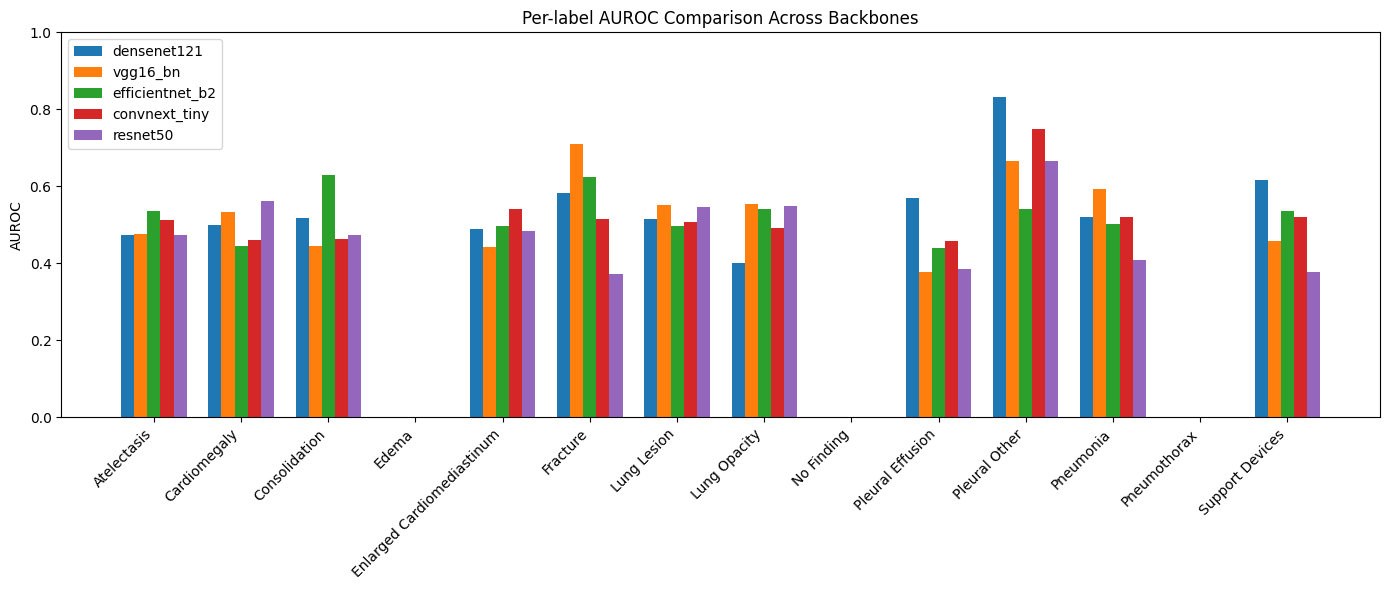

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Config ==
# Map backbone name -> CSV path
per_label_csvs = {
    "densenet121": "checkpoints/eval_densenet121/densenet121_per_label_metrics.csv",
    "vgg16_bn": "checkpoints/eval_vgg16_bn/vgg16_bn_per_label_metrics.csv",
    "efficientnet_b2": "checkpoints/eval_efficientnet_b2/efficientnet_b2_per_label_metrics.csv",
    "convnext_tiny": "checkpoints/eval_convnext_tiny/convnext_tiny_per_label_metrics.csv",
    "resnet50": "checkpoints/eval_resnet50/resnet50_per_label_metrics.csv",
s}

# === Load all AUROCs ===
df_all = None
for backbone, csv_path in per_label_csvs.items():
    df = pd.read_csv(csv_path)
    # Assuming CSV has columns: label, auroc (or similar)
    # If AUROC column has a different name, adjust here
    df = df[['Label', 'AUROC']].copy()
    df.rename(columns={'AUROC': backbone}, inplace=True)
    
    if df_all is None:
        df_all = df
    else:
        df_all = df_all.merge(df, on='Label')

# === Plot grouped bar chart ===
labels = df_all['Label'].tolist()
x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 6))

for i, backbone in enumerate(per_label_csvs.keys()):
    ax.bar(x + i*width, df_all[backbone], width, label=backbone)

ax.set_ylabel('AUROC')
ax.set_title('Per-label AUROC Comparison Across Backbones')
ax.set_xticks(x + width*2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


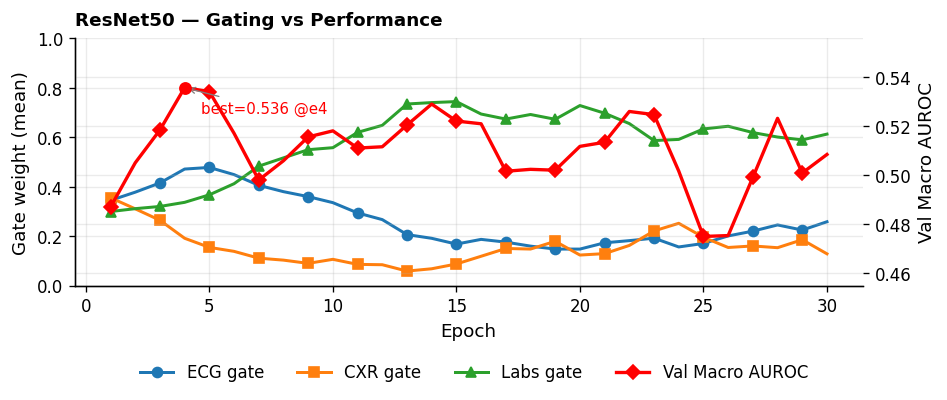

Saved: checkpoints/gate_trend_figs_pretty/gating_perf_resnet50.png


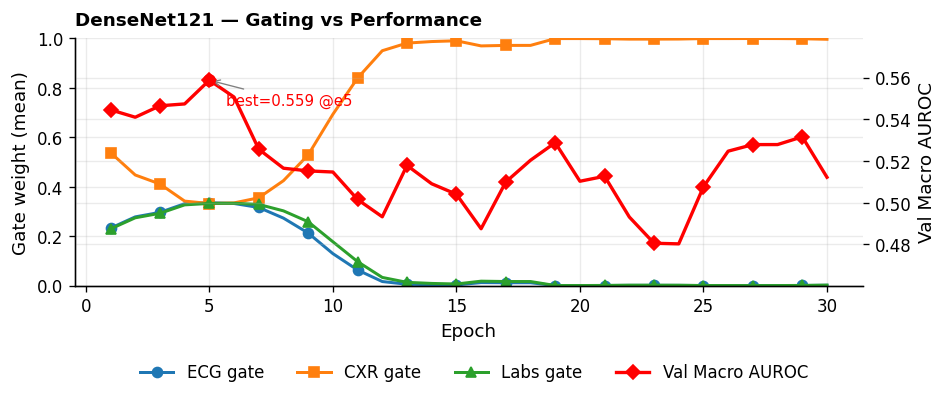

Saved: checkpoints/gate_trend_figs_pretty/gating_perf_densenet121.png


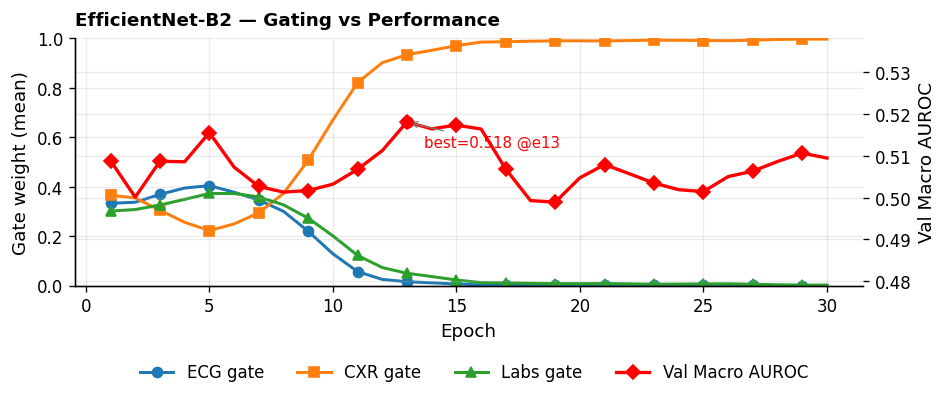

Saved: checkpoints/gate_trend_figs_pretty/gating_perf_efficientnet_b2.png


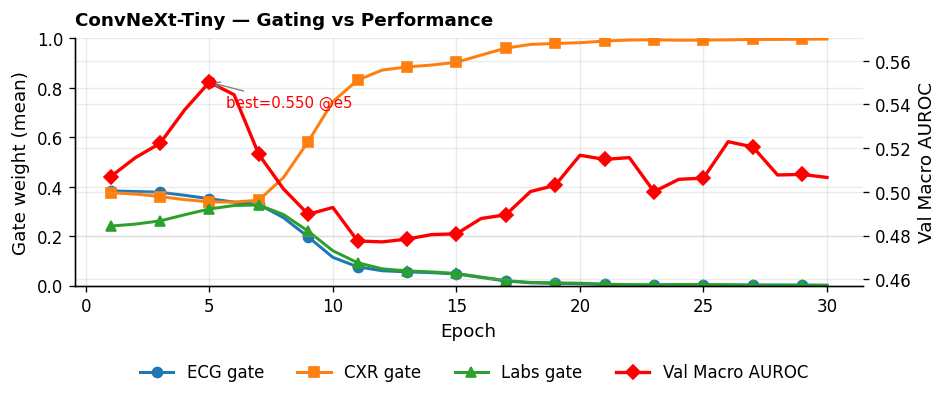

Saved: checkpoints/gate_trend_figs_pretty/gating_perf_convnext_tiny.png


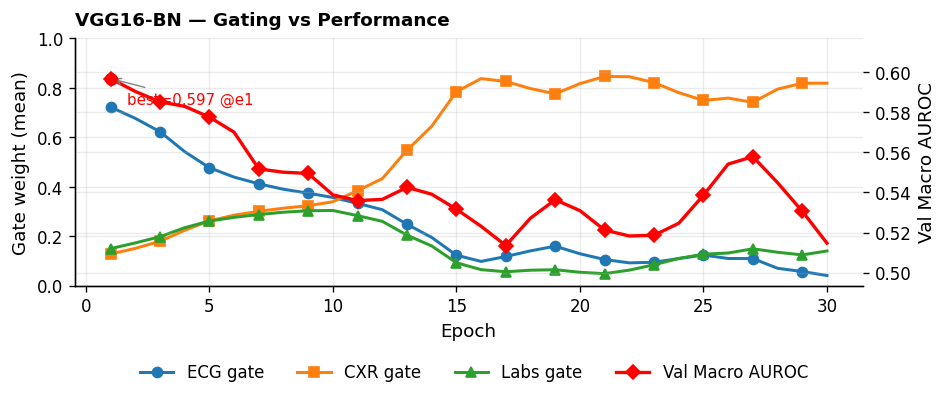

Saved: checkpoints/gate_trend_figs_pretty/gating_perf_vgg16_bn.png


In [5]:
def plot_one(backbone: str):
    csv_path = SAVE_DIR / f"gate_trends_{backbone}.csv"
    if not csv_path.exists():
        print(f"[skip] {csv_path} not found"); return
    g = _load_gate_csv(csv_path)
    epoch = g["epoch"].to_numpy()
    ecg   = _roll(g["gate_ecg"].to_numpy(), ROLL)
    cxr   = _roll(g["gate_cxr"].to_numpy(), ROLL)
    labs  = _roll(g["gate_labs"].to_numpy(), ROLL)
    has_val = "val_auroc_macro" in g.columns
    valauc = _roll(g["val_auroc_macro"].to_numpy(), ROLL) if has_val else None

    fig, ax = plt.subplots(figsize=(8, 3.2))

    # gates
    ax.plot(epoch, ecg,  marker="o", markevery=MARK_EVERY, linewidth=1.8, label="ECG gate")
    ax.plot(epoch, cxr,  marker="s", markevery=MARK_EVERY, linewidth=1.8, label="CXR gate")
    ax.plot(epoch, labs, marker="^", markevery=MARK_EVERY, linewidth=1.8, label="Labs gate")
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Gate weight (mean)")

    # cleaner title (left aligned, not bold, smaller)
    ax.set_title(f"{PRETTY.get(backbone, backbone)} — Gating vs Performance",
                 fontsize=11, loc="left", pad=8)

    if has_val:
        ax2 = ax.twinx()
        ax2.plot(epoch, valauc, marker="D", markevery=MARK_EVERY, linewidth=2.0,
                 linestyle="-", color="red", label="Val Macro AUROC")
        ax2.set_ylabel("Val Macro AUROC")
        y2min = max(0.0, np.nanmin(valauc) - 0.02)
        y2max = min(1.0, np.nanmax(valauc) + 0.02)
        ax2.set_ylim(y2min, y2max)

        # best point
        j = int(np.nanargmax(valauc))
        ax2.scatter(epoch[j], valauc[j], s=45, c="red", zorder=5)
        ax2.annotate(f"best={valauc[j]:.3f} @e{int(epoch[j])}",
                     xy=(epoch[j], valauc[j]),
                     xytext=(10, -15), textcoords="offset points",
                     fontsize=9, color="red",
                     arrowprops=dict(arrowstyle="->", lw=0.8, color="gray"))

        # legend outside bottom
        lines, labels = [], []
        for a in [ax, ax2]:
            h, l = a.get_legend_handles_labels()
            lines.extend(h); labels.extend(l)
        fig.legend(lines, labels, ncols=4, loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.05))
    else:
        fig.legend(loc="lower center", ncols=3, frameon=False, bbox_to_anchor=(0.5, -0.05))

    fig.tight_layout(rect=[0,0.05,1,1])  # leave space at bottom for legend
    out_png = out_dir / f"gating_perf_{backbone}.png"
    fig.savefig(out_png, dpi=220, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_png}")
    
for b in BACKBONES:
    plot_one(b)

In [ ]:
What the model is

We predict 14 CheXpert labels from three modalities:

CXR image → a selectable ImageNet‑pretrained backbone (ResNet‑50 / DenseNet‑121 / EfficientNet‑B2 / ConvNeXt‑Tiny / VGG16‑BN), followed by a 2048/1024/… → 128‑d reducer.

ECG (12‑lead, 1‑D signal) → a small 1‑D CNN → 128‑d.

Labs (tabular) → a 2‑layer MLP with BN+Dropout → 128‑d.

Those three 128‑d embeddings go into a learned gating module. The gate looks at the concatenated features and produces three weights (ECG, CXR, Labs) via a temperature‑scaled softmax. We take a weighted sum (“fused” feature) and also keep the original three embeddings; the classifier sees [fused, ecg, cxr, labs] (512‑d) → 256 → 14 logits. Loss is masked BCE (ignores −1 labels).

What changed vs. the “old” adaptive fusion

1) Backbones are pluggable + tamed at the start

CXR encoder is now a factory; we can sweep ResNet/DenseNet/EfficientNet/ConvNeXt/VGG with the same fusion head.

We freeze the CXR backbone for the first 1–2 epochs and give it a smaller LR (backbone_lr_scale), so it doesn’t dominate early learning.
→ Result: more balanced gates and stabler early validation.

2) Gates that don’t collapse

Temperature‑softmax with annealing: start smooth (higher temp), slowly sharpen each step; we also keep a tiny floor ε so no modality can go to exact zero instantly.

Light regularizers: small entropy/diversity nudges to keep gates exploring but not oscillating.
→ Result: early epochs show all three modalities participating; later, the gate settles based on signal.

3) Safer multimodal dropout

Structured modality dropout drops at most one modality per sample and is warmed up (higher drop at the beginning, then reduces).
→ Prevents “double‑drop” accidents that used to push the gate into bad local minima.

4) Cleaner training loop

Mixed precision (AMP) and optional EMA of weights (0.999) applied only during validation for smoother val curves.

Per‑epoch logging to CSV: val macro AUROC, val flat AUROC, gate means, time/epoch, and peak GPU GB.

Robust loaders for ECG shapes; consistent permutation to (B, 12, T).

5) Better evaluation signals

In addition to macro AUROC (mean over classes), we compute flat AUROC (all labels flattened) to show global discrimination.
→ In our runs, macro AUROC hovered ~0.54–0.59 early (hardest metric), while flat AUROC was ~0.84–0.85, which matches what we expect with class imbalance and many easy negatives.

Why these changes helped

Freeze + smaller LR for CXR prevents the high‑capacity image backbone from drowning out ECG/Labs before their encoders learn stable features.

Temperature‑controlled gates keep training smooth in the first few epochs; the tiny floor avoids zeroing.

Structured dropout improves robustness without destabilizing fusion.

EMA-on‑val reduces checkpoint noise, so “best” really means better generalization.

Better metrics & logging made the real issue obvious (macro vs flat AUROC) and let us monitor where the gate is putting its trust across epochs.